# Table of Contents
* &nbsp;
	* [Preparing the data](#Preparing-the-data)
		* [Class imbalance and data set size](#Class-imbalance-and-data-set-size)
* [Methods](#Methods)
	* [Topological features](#Topological-features)
		* [Local indexing](#Local-indexing)
			* [Common Neighbors (CN)](#Common-Neighbors-%28CN%29)
			* [Triadic Closeness (TC)](#Triadic-Closeness-%28TC%29)
		* [Global indexing](#Global-indexing)
			* [Shortest Path (SP)](#Shortest-Path-%28SP%29)
		* [Communities as features](#Communities-as-features)
			* [Katz indexing (KZI)](#Katz-indexing-%28KZI%29)
			* [Leicht, Holme, Newman (LHN2)](#Leicht,-Holme,-Newman-%28LHN2%29)
			* [Average Commute Time (ACM)](#Average-Commute-Time-%28ACM%29)
		* [Quasi global indexing](#Quasi-global-indexing)
			* [Common referrers](#Common-referrers)
			* [Local Path Indexing (LPI)](#Local-Path-Indexing-%28LPI%29)
			* [Local Random Walk (LRW)](#Local-Random-Walk-%28LRW%29)
			* [Superimposed Random Walk (SRW)](#Superimposed-Random-Walk-%28SRW%29)
	* [Node specific features](#Node-specific-features)
		* [Temporal features](#Temporal-features)
			* [Deprecating likelihoods](#Deprecating-likelihoods)
			* [Burstiness](#Burstiness)
	* [Predictive power of single features and feature correlation](#Predictive-power-of-single-features-and-feature-correlation)
* [Supervised Methods](#Supervised-Methods)
	* [Feature selection](#Feature-selection)
		* [Logistic regression](#Logistic-regression)
		* [Parameter tuning and feature selection](#Parameter-tuning-and-feature-selection)
		* [Decision trees](#Decision-trees)
	* [Random Forests](#Random-Forests)
		* [Hyper-parameter tuning and feature selection](#Hyper-parameter-tuning-and-feature-selection)


In [1]:
%%html
#<script>
#    var code_show=true; //true -> hide code at first
#
#    function code_toggle() {
#        $('div.prompt').hide(); // always hide prompt#
#
#        if (code_show){
#            $('div.input').hide();
#        } else {
#            $('div.input').show();
#        }
#        code_show = !code_show
#    }
#    $( document ).ready(code_toggle);
#</script>

In [2]:
%%html
<a href="javascript:code_toggle()">[Toggle Code]</a>

In [1]:
%%time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sys import getsizeof
import numpy as np
import random
import math
from os.path import isfile
from sklearn.externals.six import StringIO
import pydotplus
import igraph as ig
import re
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from scipy.stats import binned_statistic
from collections import *
import cPickle as pickle
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.svm import SVC, SVR
from scipy.sparse import dok_matrix
import MySQLdb as sql
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
db = sql.connect('localhost', 'root', 'root', 'enys')
court = 'cjeu'

Wall time: 23.7 s


In [2]:
%run load_data.py
GRAPH = 'cjeu'
np.random.seed(42)
random.seed(42)


# Find the greatest connected component and work on that
components = []
lengths = []
# Find the greatest component from the undirected version of the graph
for component in nx.connected_component_subgraphs(nx.Graph(G)):
    components.append(component)
    lengths.append(len(component))
# Find the GCC as the largest component and then recreate the directed graph
GCC = components[lengths.index(max(lengths))]
GCC = G.subgraph(GCC.nodes())
components = None
lengths = None
G = None

In [3]:
def calc_bag_of_words(court, metric='cosine'):
    """
    Perform bag-of-words vectorization on the full court dataset of size N and return its rowwise similarity
    
    argument:
    metric -- sklearn supported distance measure
    court -- what court to work on (cjeu or echr)
    
    returns:
    name_to_col -- mapping from node name to column
    col_to_name -- mapping from column to node name
    X -- NxN matrix of similarites
    """
    def clean_text(t):
        pat = r'[^a-zA-Z\s]'
        t = re.sub(pat, '', t.lower())
        t = " ".join([w for w in t.split(" ") if len(w) > 1])
        return t
    if isfile('pickles/{}_bow.pkl'.format(court)):
        name_to_col, col_to_name, X = pickle.load(open('pickles/{}_bow.pkl'.format(court), 'rb'))
    else:
        count_vec = CountVectorizer()
        crs = db.cursor()
        crs.execute("""SET GLOBAL max_allowed_packet=1073741824""")
        crs.execute("""SET SESSION group_concat_max_len=1073741824""")
        # Query that returns string of entire paragraphs indexed by the case ID
        query = """SELECT {0}_cases.case_true_id, 
        GROUP_CONCAT({0}_paragraphs.paragraph_content) 
        FROM {0}_paragraphs 
        INNER JOIN {0}_cases ON {0}_paragraphs.case_id = {0}_cases.id
        GROUP BY case_id""".format(court)
        crs.execute(query)
        data = zip(*crs.fetchall())
        data = (data[0], map(clean_text, data[1]))
        name_to_col = {d:i for i,d in enumerate(data[0])}
        col_to_name = {i:d for i,d in enumerate(data[0])}
        X = count_vec.fit_transform(data[1])
        with open('pickles/{}_bow.pkl'.format(court), 'wb') as fl:
            pickle.dump((name_to_col, col_to_name, X), fl)
    return (name_to_col, col_to_name, 1.0-pairwise_distances(X, metric=metric))

def get_bag_of_words(candidate_edges, G, court=GRAPH, metric='cosine'):
    """
    Return bag of words cosine similarity
    """
    results = []
    name_to_col, col_to_name, X = calc_bag_of_words(court, metric)
    for x,y,_ in candidate_edges:
        try:
            s = X[name_to_col[x], name_to_col[y]]
        except KeyError:
            s = 0.0
        results.append((x,y,{'score': s}))
    return results

def calc_tf_idf(court, metric='cosine'):
    """
    Perform tf-idf vectorization on the full court dataset of size N and return its rowwise similarity
    
    argument:
    metric -- sklearn supported distance measure
    court -- what court to work on (cjeu or echr)
    
    returns:
    name_to_col -- mapping from node name to column
    col_to_name -- mapping from column to node name
    X -- NxN matrix of similarites
    """
    def clean_text(t):
        pat = r'[^a-zA-Z\s]'
        t = re.sub(pat, '', t.lower())
        t = " ".join([w for w in t.split(" ") if len(w) > 1])
        return t
    if isfile('pickles/{}_tfidf.pkl'.format(court)):
        name_to_col, col_to_name, X = pickle.load(open('pickles/{}_tfidf.pkl'.format(court), 'rb'))
    else:
        tf_idf_vec = TfidfVectorizer()
        crs = db.cursor()
        crs.execute("""SET GLOBAL max_allowed_packet=1073741824""")
        crs.execute("""SET SESSION group_concat_max_len=1073741824""")
        # Query that returns string of entire paragraphs indexed by the case ID
        query = """SELECT {0}_cases.case_true_id, 
        GROUP_CONCAT({0}_paragraphs.paragraph_content) 
        FROM {0}_paragraphs 
        INNER JOIN {0}_cases ON {0}_paragraphs.case_id = {0}_cases.id
        GROUP BY case_id""".format(court)
        crs.execute(query)
        data = zip(*crs.fetchall())
        data = (data[0], map(clean_text, data[1]))
        name_to_col = {d:i for i,d in enumerate(data[0])}
        col_to_name = {i:d for i,d in enumerate(data[0])}
        X = tf_idf_vec.fit_transform(data[1])
        with open('pickles/{}_tfidf.pkl'.format(court), 'wb') as fl:
            pickle.dump((name_to_col, col_to_name, X), fl)
    return (name_to_col, col_to_name, 1.0-pairwise_distances(X, metric=metric))

def get_tf_idf(candidate_edges, G, court=GRAPH, metric='cosine'):
    """
    Return bag of words cosine similarity
    """
    results = []
    name_to_col, col_to_name, X = calc_tf_idf(court, metric)
    for x,y,_ in candidate_edges:
        try:
            s = X[name_to_col[x], name_to_col[y]]
        except KeyError:
            s = 0.0
        results.append((x,y,{'score': s}))
    return results
    
def successors_scoped(node, head, G):
    """
    Return the successors of a node scoped to the time specified by the head node
    
    arguments:
    node -- node to return successors for
    head -- node containing the timestamp to scope the graph to
    G -- graph containing the nodes
    """
    max_time = G.node[head]['date']
    return [n for n in G[node] if G.node[n]['date'] <= max_time]

def predecessors_scoped(node, head, G):
    """
    Return the predecessors of a node scoped to the time specified by the head node
    
    arguments:
    node -- node to return predecessors for
    head -- node containing the timestamp to scope the graph to
    G -- graph containing the nodes
    """
    max_time = G.node[head]['date']
    return [n for n in G.pred[node] if G.node[n]['date'] <= max_time]

def scoped_neighborhood(node, head_node, G):
    """
    Return the neighborhood of a node at a given timestamp
    
    arguments:
    node -- node to find the neighborhood for
    head_node -- node containing the timestamp to filter the nodes by
    G -- directed graph containing the node
    """
    max_date = G.node[head_node]['date']
    pre = predecessors_scoped(node, head_node, G)
    suc = successors_scoped(node, head_node, G)
    return list(set(pre).union(set(suc)))    
    
def scoped_out_degree(node, head_node, G):
    """
    Return the degree of a node at a given timestamp
    
    arguments:
    node -- node to return the degree for
    head_node -- node containing the timestamp to filter the nodes by
    G -- graph containing the nodes
    """
    max_date = G.node[head_node]['date']
    neighborhood = [n for n in G[node] if G.node[n]['date'] <= max_date]
    return len(neighborhood)

def scoped_in_degree(node, head_node, G):
    """
    Return the degree of a node at a given timestamp
    
    arguments:
    node -- node to return the degree for
    head_node -- node containing the timestamp to filter the nodes by
    G -- graph containing the nodes
    """
    max_date = G.node[head_node]['date']
    neighborhood = [n for n in G.pred[node] if G.node[n]['date'] <= max_date]
    return len(neighborhood)

def scoped_degree(node, head_node, G):
    """
    Return the degree of a node at a given timestamop
    """
    return len(scoped_neighborhood(node, head_node, G))

def get_common_neighbors(x,y,G):
    u = set(scoped_neighborhood(x,x,G))
    v = set(scoped_neighborhood(y,x,G))
    return u.intersection(v)

def get_neighbor_union(x,y,G):
    u = set(scoped_neighborhood(x,x,G))
    v = set(scoped_neighborhood(y,x,G))
    return u.union(v)

def get_common_referrers(x,y,G):
    common_referrers_source = {n for m in successors_scoped(x, x, G) for n in predecessors_scoped(m, x, G)} - {x}
    referrers_to_target = set(predecessors_scoped(y,x,G))
    return common_referrers_source.intersection(referrers_to_target)

    
def common_referrers(validation_set, G, weighting_scheme=None):
    """
    For a given node pair x and y, return the number of nodes that both refer to a node that x also refers and refers to y
    or f(y) intersection g(f(x)) where f returns the predeccessors of a node and g returns the successors
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
 
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        connected = y in G[x]
        if connected:
            G.remove_edge(x,y)
        cn = get_common_referrers(x,y,G)
        if weighting_scheme and weighting_scheme.is_local():
            weights = []
            for z in cn:
                weights.append(weighting_scheme.score(z, x, G) * 1.0)
            s = sum(weights)
        else:
            s = len(cn)
        if weighting_scheme and weighting_scheme.is_global():
            s = s*weighting_scheme.score(x,y,G)
        if len(non_edge) > 2:
            non_edge[2]['score'] = s
            results.append(non_edge)
        else:
            results.append(s)
        if connected:
            G.add_edge(x,y)
    return results

def common_neighbors(validation_set, G, weighting_scheme=None, recalculate=False):
    """
    Perform common neighbors scoring on a list of edges, backed by the database
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    recalculate -- Whether to load edges from the database or recalculate them all    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,GCC)
        if weighting_scheme and weighting_scheme.is_local():
            weights = []
            for z in cn:
                weights.append(weighting_scheme.score(z, x, GCC) * 1.0)
            s = sum(weights)
        else:
            s = len(cn)
        if weighting_scheme and weighting_scheme.is_global():
            s = s*weighting_scheme.score(x,y,GCC)
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

class WeightingScheme():
    
    def is_global(self):
        return self.weight_type == "global"
    def is_local(self):
        return self.weight_type == "local"
        

class Jaccard(WeightingScheme):
    
    def __init__(self):
        self.weight_type = "global"
    
    def score(self,x,y,G):
        """
        Perform jaccard scoring on a list of edges

        arguments:
        validation_set -- list of edges to score
        G -- digraph containing the nodes in the edges of the validation set

        returns:
        list of edges with score as an attribute
        """
        u = set(scoped_neighborhood(x,x,G))
        v = set(scoped_neighborhood(y,x,G))
        try:
            s = 1.0*len(u & v)/len(u | v)
        except:
            s = 0.0
        return s
    
class AdamicAdar(WeightingScheme):
    
    def __init__(self):
        self.weight_type = 'local'
        
    def score(self, z, x, G):
        """
        Return the AdamicAdar coefficient for a single neighbor z, scoped to the time of a node x
        
        arguments:
        z -- node to return the AA coefficient for
        x -- node that holds the timestamp to scope z to
        G -- graph containing x and z
        """
        deg = scoped_degree(z,x,G)
        if deg > 1:
            return 1.0/math.log(scoped_degree(z, x, G))
        else:
            return 0.0

        
class ResourceAllocation(WeightingScheme):
    
    def __init__(self):
        self.weight_type = 'local'
        
    def score(self, z, x, G):
        """
        Return the RA coefficient for a single neighbor z, scoped to the time of a node x
        
        arguments:
        z -- node to return the AA coefficient for
        x -- node that holds the timestamp to scope z to
        G -- graph containing x and z
        """
        deg = scoped_degree(z,x,G)
        if deg > 1:
            return 1.0/scoped_degree(z, x, G)
        else:
            return 0.0


        
class LeichtHolmeNewman(WeightingScheme):
    
    def __init__(self):
        self.weight_type = 'global'
        
    def score(self, x, y, G):
        """
        Return the RA coefficient for a single neighbor z, scoped to the time of a node x
        
        arguments:
        z -- node to return the AA coefficient for
        x -- node that holds the timestamp to scope z to
        G -- graph containing x and z
        """
        x_deg = scoped_degree(x,x,G)
        y_deg = scoped_degree(y,x,G)
        if x_deg > 0 and y_deg > 0:
            return 1.0/x_deg*y_deg
        else:
            return 0.0

class HubDepressed(WeightingScheme):
    def __init__(self):
        self.weight_type = 'local'

    def score(self, x, y, G):
        x_deg = scoped_degree(x,x,G)
        y_deg = scoped_degree(y,x,G)
        if x_deg != 0 and y_deg != 0:
            return 1.0/min(x_deg, y_deg)
        else:
            return 0.0
    
class HubPromoted(WeightingScheme):
    def __init__(self):
        self.weight_type = 'global'

    def score(self, x, y, G):
        x_deg = scoped_degree(x,x,G)
        y_deg = scoped_degree(y,x,G)
        if x_deg != 0 or y_deg != 0:
            return 1.0/max(x_deg, y_deg)
        else:
            return 0.0

class Salton(WeightingScheme):
    def __init__(self):
        self.weight_type = 'global'


    def score(self, x, y, G):
        x_deg = scoped_degree(x,x,G)
        y_deg = scoped_degree(y,x,G)
        if x_deg != 0 and y_deg != 0:
            return 1.0/math.sqrt(x_deg*y_deg)
        else:
            return 0.0

def hub_depressed(validation_set, G):
    """
    Find the hub promoted similarity of a single edge
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,G)
        if scoped_out_degree(x, x, G) != 0 and scoped_in_degree(y, x, G) != 0:
            s = 1.0*len(cn)/min(scoped_out_degree(x, x, G),scoped_in_degree(y, x, G))
        else:
            s = 0.0
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def hub_promoted(validation_set, G):
    """
    Find the hub promoted similarity of a single edge
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,G)
        if scoped_out_degree(x, x, G) != 0 or scoped_in_degree(y, x, G) != 0:
            s = 1.0*len(cn)/max(scoped_out_degree(x, x, G),scoped_in_degree(y, x, G))
        else:
            s = 0.0
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def salton(validation_set, G):
    """
    Find the salton similarity of a single edge
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,G)
        if scoped_out_degree(x, x, G) == 0 or scoped_in_degree(y, x, G) == 0:
            s = 0.0
        else:
            s = 1.0*len(cn)/math.sqrt(scoped_out_degree(x, x, G)*scoped_in_degree(y, x, G))
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def leicht_holme_newman(validation_set, G):
    """
    Perform LHN1 scoring on a single edge
    
    arguments:
    non_edge -- edge tuple specified by node endpoints
    G -- graph containing the nodes in the edge
    
    return:
    edges with the score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,G)
        if scoped_out_degree(x, x, G) == 0 or scoped_in_degree(y, x, G) == 0:
            s = 0.0
        else:
            s = 1.0*len(cn)/(scoped_out_degree(x, x, G)*scoped_in_degree(y, x, G))
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def adamic_adar(validation_set, G):
    """
    Perform jaccard scoring on a list of edges
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        neighbors = get_common_neighbors(x,y,G)
        s = 1*sum([1.0/math.log(scoped_degree(node, x, G)) for node in neighbors if scoped_degree(node, x, G) > 1])
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def resource_allocation(validation_set, G):
    """
    Perform resource allocation scoring on a list of edges
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        neighbors = get_common_neighbors(x,y,G)
        s = sum([1.0/scoped_degree(node, x, G) for node in neighbors if scoped_degree(node, x, G) > 1])
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results


def preferential_attachment(validation_set, G):
    """
    Perform preferential attachment scoring on a list of edges
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """

    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        s = scoped_out_degree(x,x,G)*scoped_in_degree(y,x,G)
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def triadic_closeness(validation_set, G, census=None, weighting_scheme=None):
    
    results = []
    if census == None:
        census = triadic_distribution(G)
    for non_edge in validation_set:
        
        x = non_edge[0]
        y = non_edge[1]
        connected = y in G[x]
        if connected:
            G.remove_edge(x,y)
        u = set(scoped_neighborhood(x,x,G))
        v = set(scoped_neighborhood(y,x,G))
        cn = u.intersection(v)
        t_score = []
        for z in cn:
            triad = get_triad(x,z,y,G)
            if census[triad] == 0:
                continue
            try:
                F2 = census[triad+30]
            except KeyError:
                F2 = 0.0
            try:
                F1 = census[triad+10]
            except KeyError:
                F1 = 0.0
            
            # Add in any weighting schemes that work on the individual nodes in the common neighborhood
            if weighting_scheme and weighting_scheme.is_local():
                score = weighting_scheme.score(z, x, GCC)*(1.0*F1 + F2)/census[triad]
            else:
                score = (1.0*F1 + F2)/census[triad]
            
            t_score.append(score)
        s = sum(t_score)
        if weighting_scheme and weighting_scheme.is_global():
            s = s*weighting_scheme.score(x, y, G)
        if len(non_edge) > 2:
            non_edge[2]['score'] = s
            results.append(non_edge)
        else:
            results.append(s)
        if connected:
            G.add_edge(x,y)
    return results

def triadic_distribution(G):
    """
    Return the distribution of closed triad configurations for a graph
    The distribution is labelled as in the paper by Schall
    http://link.springer.com.proxy.findit.dtu.dk/article/10.1007/s13278-014-0157-9
    
    arguments:
    G -- directed graph
    
    returns:
    Dict of labels with counts
    """
    
    # Integer labels as presented in the paper
    TRIAD_NAMES = range(1,10) + range(11, 20) + range(21,30) + range (31, 40)
    census = {name: 0 for name in TRIAD_NAMES}
    for u in G.nodes_iter():
        u_neighbors = list(set(G.successors(u)) | set(G.predecessors(u)))
        for z in u_neighbors:
            z_neighbors = list((set(G.successors(z)) | set(G.predecessors(z))) - {u} )
            for v in z_neighbors:
                name = get_triad(u,z,v, G)
                census[name] += 1
    return census


def get_triad(u,z,v,G):
    """
    Return the triad created by the nodes u,v and z
    This implementation is quite probably awful.
    
    parameters:
    
    u -- starting node
    z -- connecting node
    v -- ending node
    G -- DiGraph containing the nodes
    
    returns:
    Dict containing closed triad counts
    """
    
    u_out = G[u]
    v_out = G[v]
    z_out = G[z]
    id = 0
    
    if v in u_out and u in v_out:
        id = 30
    elif u in v_out:
        id = 20
    elif v in u_out:
        id = 10
    
    if u in z_out and z not in u_out:
        id += 7
        if v in z_out and z not in v_out:
            return id + 2
        elif z in v_out and v not in z_out:
            return id + 1
        elif z in v_out and v in z_out:
            return id
        raise Exception("Error in finding triad")
    elif z in v_out and v not in z_out:
        id += 5
        if z in u_out and u not in z_out:
            return id + 1
        elif z in u_out and u in z_out:
            return id
        raise Exception("Error in finding triad")
    elif z in u_out and u not in z_out:
        id += 3
        if v in z_out and z not in v_out:
            return id + 1
        if v in z_out and z in v_out:
            return id
        raise Exception("Error in finding triad")
    elif z in u_out and u in z_out:
        if v in z_out and z not in v_out:
            return id + 2
        elif v in z_out and z in v_out:
            return id + 1
    
    raise Exception("No triad found")
        

def get_closed_triads(x, y, G):
    """
    Return the closed triads generated by adding a link from x to y.
    Triads are classified according to the triadic_census algorithm of NetworkX based on 
    http://vlado.fmf.uni-lj.si/pub/networks/doc/triads/triads.pdf
    """
    
    # Taken directly from nx.triadic_census source
    TRIAD_NAMES = ('003', '012', '102', '021D', '021U', '021C', '111D', '111U',
                   '030T', '030C', '201', '120D', '120U', '120C', '210', '300')
    census = {name: 0 for name in TRIAD_NAMES}
    
    x_in = set(G.predecessors(x))
    y_in = set(G.predecessors(y))
    x_out = set(G.successors(x))
    y_out = set(G.successors(y))
    
    for node in x_in | y_in | x_out | y_out:
        # y refers to a node that refers to x
        if node in x_in and node in y_out:
            census['030C'] += 1
        # y is being referred to by a node that refers to x
        if node in x_in and node in y_in:
            census['030T'] += 1
        # x refers to a node that refers to y
        if node in x_out and node in y_in:
            census['030T'] += 1
        # x refers to a node that y refers to
        if node in x_out and node in y_out:
            census['030T'] += 1

def time_difference(candidate_edges, G):
    """
    Return the time difference for a set of edges
    """

    results = []
    
    results = [(x,y, {'score': int((G.node[x]['date'] - G.node[y]['date']).days)}) for x,y,_ in candidate_edges]
    return results

def shortest_dag_path(candidate_edges, G):
    results = []
    longest_possible_path = len(G.nodes())
    H = nx.Graph(G)
    for x,y,_ in candidate_edges:
        connected = y in G[x].keys()
        if connected:
            H.remove_edge(x,y)
        try:
            results.append((x,y,{'score': nx.shortest_path_length(H,x,y)}))
        except:
            results.append((x,y, {'score': longest_possible_path}))
        if connected:
            H.add_edge(x,y)
    return results
        
class CommonNeighbors():
    """
    An experiment that scores a list of edges based on the number of common neighbors between the source and the target node
    """
    
    def __init__(self, weighting_scheme=None):
        self.weighting_scheme = weighting_scheme
        
    def valid_false_edges(self, G, source_nodes):
        """
        Returns a list of edges that do not exist in G and will score highly on the common neighbors index
        
        Parameters
        ----------
        G: networkX.Graph
            Graph to perform experiment on
        source_nodes: list of tuples
            Nodes containing the true edges to be scored
        """
        false_validation_edges = [(source, target) for source in source_nodes
                   for neighbor in G[source].keys()
                   for target in set(scoped_neighborhood(neighbor, source, G)) - {source} if target not in G[source].keys()]
        
        false_validation_edges = list(set(false_validation_edges))
        for i in range(len(false_validation_edges)):
            edge = false_validation_edges[i]
            # Add date information to the non-edge
            false_validation_edges[i] = edge + ({'date': G.node[edge[0]]['date']},)
        
        return false_validation_edges
        
    def score_edges(self, edges, G):
        return common_neighbors(edges, G, self.weighting_scheme)
    
class TriadicCloseness(CommonNeighbors):
    
    def __init__(self, cache_distribution=False, weighting_scheme=None):
        self.cache_distribution = cache_distribution
        self.census = None
        self.weighting_scheme=weighting_scheme
    
    def score_edges(self, edges, G):
        
        if self.cache_distribution == True and self.census == None:
            self.census = triadic_distribution(G)
            return triadic_closeness(edges, G, self.census, self.weighting_scheme)
        else:
            return triadic_closeness(edges, G, self.census, self.weighting_scheme)
    
class CommonReferrers():
    
    def __init__(self, weighting_scheme=None):
        self.weighting_scheme = weighting_scheme
    
    def valid_false_edges(self, G, source_nodes):
        """
        Returns a list of edges that do not exist in G and will score highly on the common referrers index
        
        Parameters
        ----------
        G: networkX.Graph
            Graph to perform experiment on
        source_nodes: list of tuples
            Nodes containing the true edges to be scored
        """
        non_edges = []
        for source in source_nodes:
            neighbors = G[source].keys()
            corefs = set()
            for neighbor in neighbors:
                corefs = corefs | {c for c in predecessors_scoped(neighbor, source, G)}
            [non_edges.append((source, referee)) for coref in (corefs - {source}) 
                                                 for referee in set(successors_scoped(coref, source, G)) - set(neighbors)]
            
        for i in range(len(non_edges)):
            edge = non_edges[i]
            # Add date information to the non-edge
            non_edges[i] = edge + ({'date': G.node[edge[0]]['date']},)
        
        return non_edges
    
    def score_edges(self, edges, G):
        return common_referrers(edges, G, self.weighting_scheme)
            
                
def valid_random_non_edges(graph, n):
    """
    Returns randomized, non-existent links between nodes in the graph that are guaranteed to observe causality.

    Parameters
    ----------
    graph : NetworkX graph.
        Graph to find non-existent edges.
    n : integer
        Number of non-existent edges to find

    Returns
    -------
    non_edges : list
        List of n edges that are not in the graph.
    """
    result_pairs = {}
    # Sort edges according to age
    sorted_edges =[node for node, data in sorted(graph.nodes(data=True), key=lambda x: x[1]['date'], reverse=True)]
    node_set = set(graph.nodes())
    candidates = list(np.random.choice(sorted_edges, n, replace=True))
    i = 0
    while i < len(candidates):
        u = candidates[i]
        if not u in result_pairs.keys():
            result_pairs[u] = []
            
        # Make sure the potential neighbors respect causality with a resolution equal to the timestamp
        cand_index = sorted_edges.index(u)
        potential_neighbors = set(sorted_edges[cand_index:])
        if graph.is_directed():
            neighbors = set(graph.successors(u)).union(set(graph.predecessors(u)))
        else:
            neighbors = set(graph.neighbors(u))
        # Make sure the potential neighbors respect causality
        non_neighbors = list(potential_neighbors - neighbors - set(result_pairs[u]))
        # The oldest node will have a neighborhood of Ø, so add a new candidate to the list in that case
        if len(non_neighbors) == 0:
            candidates.append(random.choice(graph.nodes()))
        else:    
            result_pairs[u].append(random.choice(non_neighbors))
        i += 1
    
    return [(k,v) for k, arr in result_pairs.iteritems() for v in arr]
        

def k_fold_validate(G, k, experiment):
    """
    K-fold validation of some specified function
    
    arguments:
    G -- Graph to perform the function on
    k -- number of folds
    fun -- function to be evaluated
    kwargs -- arguments to be passed to the evaluated function
    
    return:
    List of lists of scored predictions
    """
    results = []
    validation_sets = []
    edges = G.edges(data=True)
    random.shuffle(edges)
    # Find all edges that do not exist in the graph, but will return a high score
    false_edges = experiment.valid_false_edges(G, G.nodes())
    random.shuffle(false_edges)
    M = len(false_edges)/k
    # Find the number of true members in the validation set
    N = len(edges)/k
    for i in range(0,k):
        validation_sets.append(edges[i*N:(i+1)*N] + false_edges[i*M:(i+1)*M])
    for val_edges in validation_sets:
        res = experiment.score_edges(val_edges, G)
        # If not shuffled, subsequent sorting algorithms will always rank true edges higher than false edges when they have
        # the same score
        random.shuffle(res)
        results.append(res)
    return results

def k_fold_nodes(G, k, experiment):
    """
    Perform k-fold validation on the nodes of the graph.
    This validation only tests relevant false edges, i.e. edges where we are fairly certain the score won't come out as 0.0
    making it useful for precision / recall, but not for AUC. The true edges can still score 0.0
    """
    results = []
    nodes = G.nodes()
    random.shuffle(nodes)
    N = len(nodes)/k
    validation_sets = []
    for i in range(0, k):
        validation_sets.append(nodes[i*N:(i+1)*N])
    for true_nodes in validation_sets:
        # Validation sets consist of all possible the edges in 
        val_edges = [(source, target, G[source][target]) for source in true_nodes for target in G[source].keys()]
        val_set = set((source, target) for (source, target, _) in val_edges)
        G_train = G.copy()
        G_train.remove_edges_from(val_edges)
        false_validation_edges = experiment.valid_false_edges(G, true_nodes)
        false_validation_edges = [(x,y,data) for (x,y,data) in false_validation_edges if (x,y) not in val_set]
        validation_set = val_edges + false_validation_edges
        # If not shuffled, subsequent sorting algorithms will always rank true edges higher than false edges when they have
        # the same score
        random.shuffle(validation_set)        
        results.append(experiment.score_edges(validation_set, G))
    return results

def at_degree_validation(G, experiment, degree):
    if degree < 2:
        raise Exception('Degree must be larger than 2')
    res = {}
    H = G.copy()
    to_be_evaluated = []
    # Randomly sample n nodes from each degree bin
    deg=nx.degree(G)
    h = {}
    for node in G.nodes_iter():
        if G.out_degree(node) == degree:
            to_be_evaluated.append(node)
    for node in to_be_evaluated:
        res[node] = []
        e = G.edges(node, data=True)
        if not len(e) == degree:
            raise Exception("Mismatch: {}".format(len(e)))
        G.remove_edges_from(e[1:degree-1])
        for i in range(1, degree):
            to_be_scored = experiment.valid_false_edges(H, [node]) + e[i:degree]
            random.shuffle(to_be_scored)
            scored_edges = experiment.score_edges(to_be_scored, G)
            [edge[2].update({'n_edges': i}) for edge in scored_edges]
            res[node] += scored_edges
            #res[node][i] = scored_edges
            G.add_edge(e[i][0], e[i][1])
    return res
        
def precision(G, results, L):
    """
    Find the ratio of the true positives to trues
    
    arguments:
    G -- graph the results are based on
    results -- list of lists of scored predictions
    L -- number of results to be considered
    
    return:
    List of precisions for each set of results
    """
    # Sort the results with descending scores
    results = [sorted(result, key=lambda x: x[2]['score'], reverse=True) for result in results]
    for res in results:
        if L > len(res):
            raise ArgumentError("L is larger than the number of results")
    edge_set = set(G.edges())
    # True positives exist in both the edge set and the result set
    true_positives = [[(edge[0],edge[1]) for edge in result[0:L] if (edge[0], edge[1]) in edge_set] for result in results]
    return [1.0*len(trues)/L for trues in true_positives]

def per_node_precision(G, results):
    """
    results : dict
        A dict of {node: [e1, e2, ... e_n]} where e is an edge of the form (source, target, {'n_edges': x, 'score': y}) where
        n_edges number of edges the node had when the prediction was made.
    """
    
    m = 43
    # Create a dict that all the edges sorted by score and grouped by n_edges and then node
    s = {n: {k: [] for k in range(1,m+1)} for n in results.iterkeys()}
    for node, node_res in results.iteritems():
        # Sort the entire list of results
        srt = sorted(node_res, key=lambda x: x[2]['score'], reverse=True)
        for x,y,data in srt:
            # Add each result to its proper bin
            s[node][data['n_edges']].append((x,y,{'score': data['score']}))
    precisions = {k: [] for k in range(1,m+1)}
    edge_set = set(G.edges())
    for node, node_res in s.iteritems():
        n = G.out_degree(node)
        for level, results in node_res.iteritems():
            L = n-level
            if len(results) == 0:
                break
            precisions[level].append(1.0*len([(edge[0],edge[1]) for edge in results[0:L] if (edge[0], edge[1]) in edge_set])/L)
    return precisions
    

def precision2(G, results, L):
    """
    Find the ratio of the true positives to trues
    
    arguments:
    G -- graph the results are based on
    results -- list of lists of scored predictions
    L -- number of results to be considered
    
    return:
    List of precisions for each set of results
    """
    # Sort the results with descending scores
    #results = heapq.nlargest(L, results, key=lambda x: x[2]['score'])
    edge_set = set(G.edges())
    # True positives exist in both the edge set and the result set
    true_positives = [(edge[0],edge[1]) for edge in results if (edge[0], edge[1]) in edge_set]
    return 1.0*len(true_positives)/L

def AUC(G, results):
    """
    Perform n trials where the score of a non-edge and an edge in the result is compared. Count the number of trials where
    the edge had the higher score as n' and the number of times the score was equal as n'' and return the AUC as (n' + n'')/n.
    
    arguments:
    G -- graph the results are based on
    results -- list of lists of scored predictions
    
    return:
    List of precisions for each set of results
    """
    
    edge_set = set(G.edges())
    AUC = []
    for result_set in results:
        true_edges = []
        false_edges = []
        for (x,y,data) in result_set:
            if (x,y) in edge_set:
                true_edges.append((x,y,data))
            else:
                false_edges.append((x,y,data))
        
        random.shuffle(true_edges)
        random.shuffle(false_edges)
        n = len(true_edges)
        n_better = 0.0
        n_same = 0.0
        for i in range(0, n):
            if true_edges[i][2]['score'] > false_edges[i][2]['score']:
                n_better += 1.0
            if true_edges[i][2]['score'] == false_edges[i][2]['score']:
                n_same += 1.0
        AUC.append((n_better + 0.5*n_same)/n)
    return AUC

def in_cluster(candidate_edges, G):
    results = []
    nx.write_gml(G, 'G.gml', stringizer=lambda x: str(x))
    G_i = ig.Graph.Read_GML('G.gml')
    vc = G_i.community_infomap()
    node_to_cluster = {}
    for node, cluster in zip(G_i.vs(), vc.membership):
        node_to_cluster[node['label']] = cluster
    for x,y,data in candidate_edges:
        s = False
        if node_to_cluster[x] == node_to_cluster[y]:
            s = True
        results.append((x,y,{'score': s}))
    return results

def slice_graph_by_year(start_year, end_year, G):
    """
    Returns all nodes created within a range of years
    """
    if datetime.date(start_year, 1, 1) < datetime.date(end_year, 1, 1):
        raise ArgumentError("The starting year must be larger than or equal to the ending year")
    t1 = datetime.date(start_year, 12, 31)
    t2 = datetime.date(end_year, 1, 1)
    
    return [n for n in G.nodes(data=True) if n[1]['date'] >= t2 and n[1]['date'] < t1]

def get_features(G, cand_edges, year, load=True):
    
    def load_or_extract(function, f_name, year, cand_edges, G, load=True, dtype=None):
        path = 'pickles/'+GRAPH+'_'+year+'_'+f_name+'.pkl'
        if isfile(path) and load:
            res = pd.read_pickle(path)
        else:
            res = pd.Series([data['score'] for x,y, data in function(cand_edges, G)], index=[(x,y) for x,y,_ in cand_edges], dtype=dtype)
            if load:
                res.to_pickle(path)
        return res
                              
    df = pd.DataFrame(index=[(x,y) for x,y,_ in cand_edges])
    true_edges = set(G.edges())
    #df['shortest_path'] = load_or_extract(shortest_dag_path, 'shortest_path', str(year), cand_edges, G, dtype='uint16', load=load)
    df['edge'] = pd.Series([True if (x,y) in true_edges else False for x,y,_ in cand_edges], index=[(x,y) for x,y,_ in cand_edges])
    df['triadic_closeness'] = load_or_extract(triadic_closeness, 'triadic_closeness', str(year), cand_edges, G, load)
    df['bag_of_words'] = load_or_extract(get_bag_of_words, 'bag_of_words', str(year), cand_edges, G, load)
    df['tf_idf'] = load_or_extract(get_tf_idf, 'tf_idf', str(year), cand_edges, G, load)
    df['in_cluster'] = load_or_extract(in_cluster, 'in_cluster', str(year), cand_edges, G, load)
    df['common_neighbors'] = load_or_extract(common_neighbors, 'common_neighbors', str(year), cand_edges, G, dtype='uint16', load=load)
    df['time_difference'] = load_or_extract(time_difference, 'time_difference', str(year), cand_edges, G, dtype='uint16', load=load)
    df['common_referrers'] = load_or_extract(common_referrers, 'common_referrers', str(year), cand_edges, G, dtype='uint16', load=load)
    #df['src_degree'] = pd.Series([len(G[x]) for x, _, __ in cand_edges], dtype='uint16')
    #df['trg_degree'] = pd.Series([len(G[y]) for _, y, __ in cand_edges], dtype='uint16')
    df['preferential_attachment'] = load_or_extract(preferential_attachment, 'preferential_attachment', 
                                                    str(year), cand_edges, G, dtype='uint32', load=load)
    df['adamic_adar'] = load_or_extract(adamic_adar, 'adamic_adar', str(year), cand_edges, G, load)
    df['leicht_holme_newman'] = load_or_extract(leicht_holme_newman, 
                                                'leicht_holme_newman', str(year), cand_edges, G, load)
    df['resource_allocation'] = load_or_extract(resource_allocation, 
                                                'resource_allocation', str(year), cand_edges, G, load)
    return df

In [32]:
%%time
# Prepare a single year test set
test_year = 2013
GRAPH = 'cjeu'
nodes_test = [n[0] for n in slice_graph_by_year(test_year, test_year, GCC)]
G_train = GCC.copy()
G_train.remove_nodes_from(nodes_test)
test_candidates = [(source, target, {}) for target in GCC.nodes() for source in nodes_test if not source==target]
test_data = get_features(GCC, test_candidates, test_year)
y_test = test_data['edge']
X_test = test_data.ix[:, [col for col in test_data.columns if col not in ['edge', 'source', 'target']]]
del test_data

Wall time: 1min 51s


In [33]:
%%time
# Training set consisting of the nodes of the preceding year
train_year = 2012
nodes_train = [n[0] for n in slice_graph_by_year(train_year, train_year, G_train)]
train_candidates = [(source, target, {}) for target in G_train.nodes() for source in nodes_train if not source==target]
train_data = get_features(G_train, train_candidates, train_year)
y_train = train_data['edge']
X_train = train_data.loc[:, [col for col in train_data.columns if col not in ['edge', 'source', 'target']]]
assert len(set(y_train.index) - set(X_train.index)) == 0
print "Edge to non-edge ratio: {}".format(1.0*sum(y_train == True) / len(y_train))
# Ensure that there is no overlap between test and train set
assert len(set([(x,y) for x,y,_ in train_candidates]).intersection(set([(x,y) for x,y,_ in test_candidates]))) == 0
del train_data

Edge to non-edge ratio: 0.000920879928598
Wall time: 1min 45s


## Model evaluation over time

Since the available dataset stretches from 1968 to 2013 it is possible to evaluate how classifiers trained and tested at different points in time perform and evolve.

6 testing years are chosen with 5 year intervals with training sets that contain all potential edges of nodes added the last 3 years. Since the number of nodes per year and the accompanying edges is relatively constant the dataset becomes increasingly imbalanced for more recent testing years.

In [ ]:
%%time
G_cur = GCC.copy()
forests = {}
lrs = {}
years =  [2013, 2008, 2003, 1998, 1993, 1988]
for year in years:
    if isfile('pickles/rf_{}.pkl'.format(year)) and isfile('pickles/lr_{}.pkl'.format(year)):
        forests[year] = pickle.load(open('pickles/rf_{}.pkl'.format(year), 'rb'))
        lrs[year] = pickle.load(open('pickles/lr_{}.okl'.format(year), 'rb'))
        print "{} done and loaded".format(year)
    else:
        training_years = range(year-3, year)
        training_years.reverse()
        train_data = pd.DataFrame()
        for training_year in training_years:
            G_cur.remove_nodes_from([n[0] for n in slice_graph_by_year(2013, training_year+1, G_cur)])
            nodes_train = [n[0] for n in slice_graph_by_year(training_year, training_year, G_cur)]
            train_candidates = [(source, target, {}) for target in G_cur.nodes() for source in nodes_train if not source==target]
            train_data=train_data.append(get_features(G_cur, train_candidates, training_year))
        rf = RandomForestClassifier(**best_params)
        lr = LogisticRegression()
        lr.fit(train_data.loc[:, [col for col in train_data.columns if col not in ['edge', 'source', 'target']]], train_data['edge'])
        with open('pickles/lr_{}.pkl'.format(year), 'wb') as fl:
            pickle.dump(lr, fl)
        lrs[year] = lr
        rf.fit(train_data.loc[:, [col for col in train_data.columns if col not in ['edge', 'source', 'target']]], train_data['edge'])
        with open('pickles/rf_{}.pkl'.format(year), 'wb') as fl:
            pickle.dump(rf, fl)
        forests[year] = rf
        print "{} done and pickled".format(year)

In [5]:
%%time
if isfile('pickles/prediction_evolution.pkl'):
    labels, rf_probs, lr_probs = pickle.load(open('pickles/prediction_evolution.pkl', 'rb'))
else:
    years =  [2013, 2008, 2003, 1998, 1993, 1988]
    rf_probs = {}
    lr_probs = {}
    labels = {}
    for year in years:
        G_cur = GCC.copy()
        if isfile('pickles/rf_{}.pkl'.format(year)) and isfile('pickles/lr_{}.pkl'.format(year)):
            forest = pickle.load(open('pickles/rf_{}.pkl'.format(year), 'rb'))
            lr = pickle.load(open('pickles/lr_{}.pkl'.format(year), 'rb'))
            if year < 2013:
                G_cur.remove_nodes_from([n[0] for n in slice_graph_by_year(2013, testing_year+1, G_cur)])
            nodes_test = [n[0] for n in slice_graph_by_year(testing_year, testing_year, G_cur)]
            test_candidates = [(source, target, {}) for target in G_cur.nodes() for source in nodes_test if not source==target]
            test_data = get_features(G_cur, test_candidates, testing_year).dropna(axis=0)
            labels[testing_year] = test_data['edge']
            rf_probs[testing_year] = forest.predict_proba(
                test_data.loc[:, [col for col in test_data.columns if col not in ['edge', 'source', 'target']]])
            lr_probs[testing_year] = lr.predict_proba(
                test_data.loc[:, [col for col in test_data.columns if col not in ['edge', 'source', 'target']]])
        else:
            print "Forest or LR not calculated for year"
            break
    pickle.dump([labels, rf_probs, lr_probs], open('pickles/prediction_evolution.pkl', 'wb'))

Wall time: 1min 19s


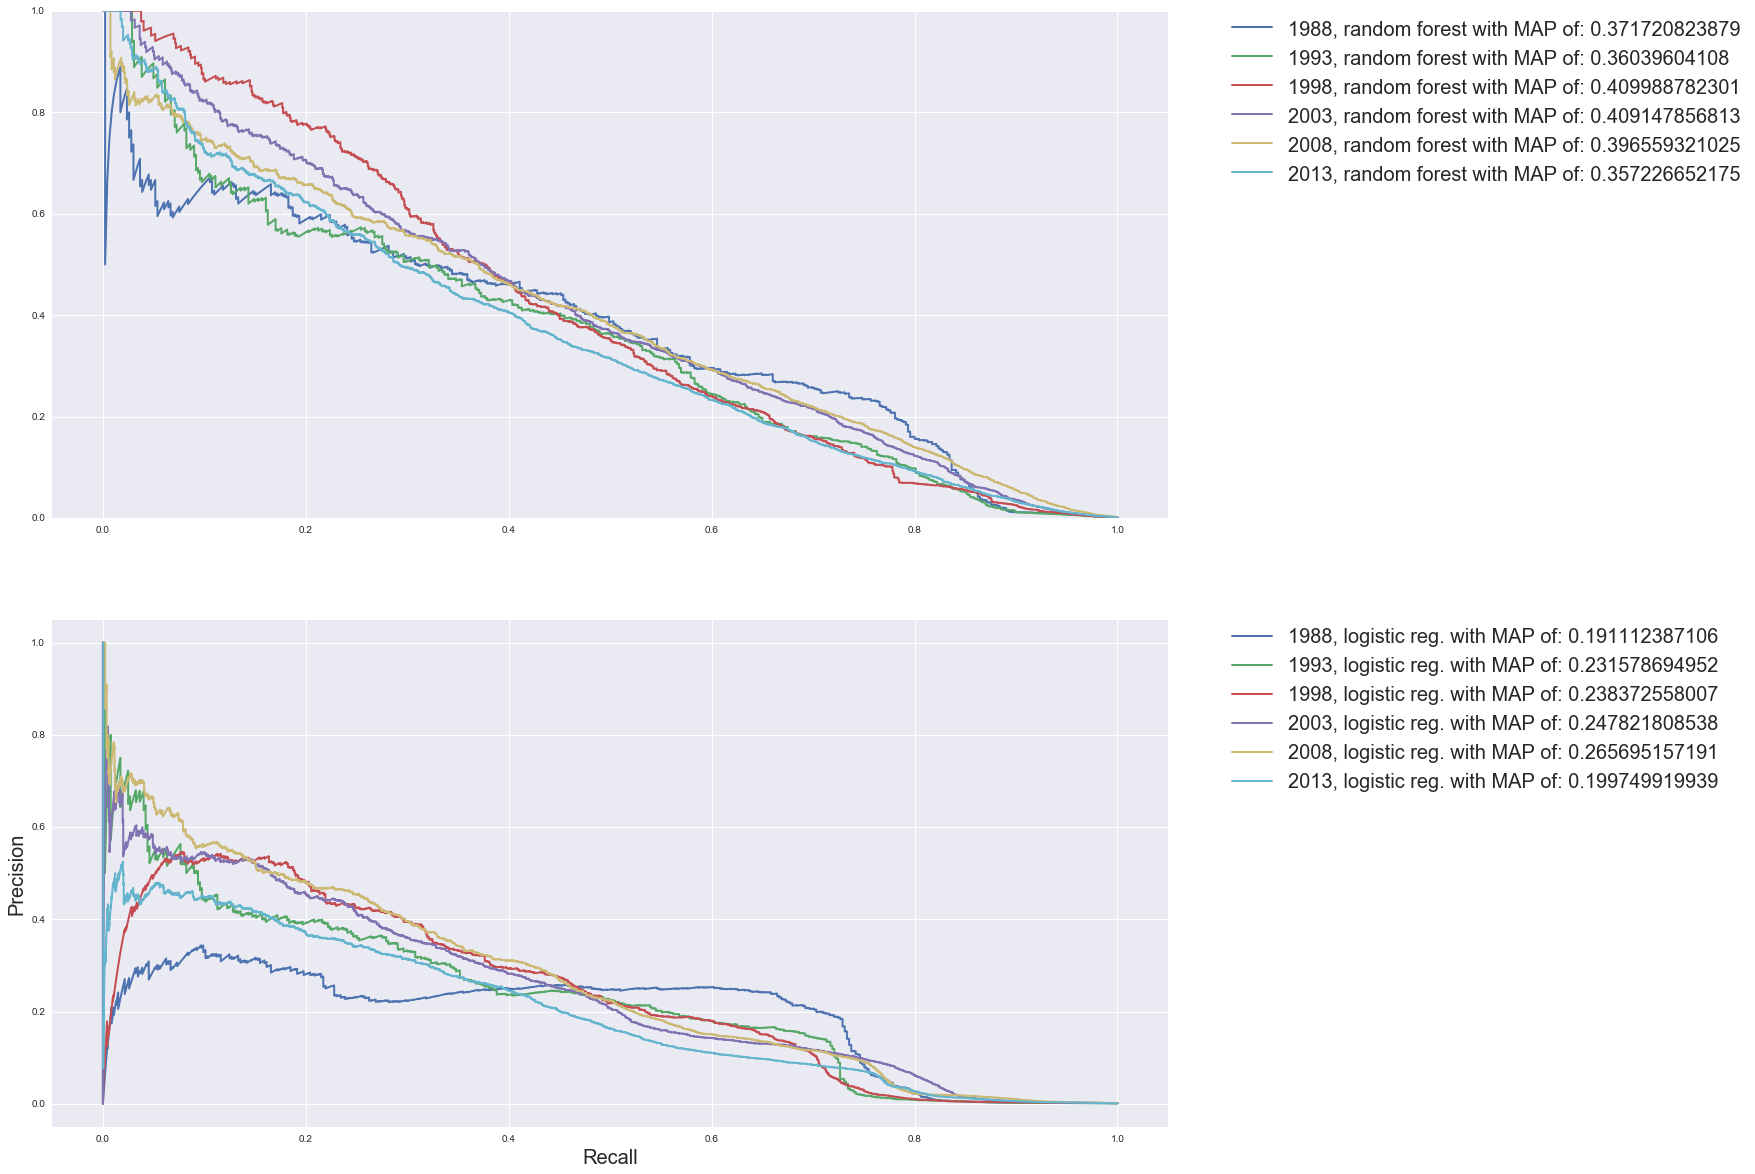

In [10]:
years = labels.keys()
plt.figure(figsize=(20,20))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex=ax1)
for year in years:
    rf_map = average_precision_score(labels[year], rf_probs[year][:,1])
    lr_map = average_precision_score(labels[year], lr_probs[year][:,1])
    precision_rf, recall_rf, _ = precision_recall_curve(labels[year], rf_probs[year][:,1])
    precision_lr, recall_lr, _ = precision_recall_curve(labels[year], lr_probs[year][:,1])
    ax1.plot(recall_rf, precision_rf, lw=2, label='{}, random forest with MAP of: {}'.format(year, rf_map))
    ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20)
    ax2.plot(recall_lr, precision_lr, lw=2, label='{}, logistic reg. with MAP of: {}'.format(year, lr_map))
    ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20)
    

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.show()

plt.axes

In [ ]:
for year, reg in lrs.iteritems():
    print "{}:".format(year)
    t=""
    v=""
    for coef, name in zip(reg.coef_[0], X_test.columns.values):
        t += "{:<.7} | ".format(name)
        v += "{:7.3f} | ".format(coef)
    print t
    print v

In [ ]:
coef

## Preparing the data

The large dataset makes prediction times very long and the class imbalance biases heavily toward predicting the negative class.

### Class imbalance and data set size

Since there are $V^2$ possible links between vertices and only a small part of them will turn out to be actual true links the dataset suffers highly from class imbalance, which for some classifiers can lead to solutions that are biased to predicting the majority class while others are perfectly able to handle imbalanced classes without bias.

If it presents a problem class imbalance can be handled by
* Weigthing the different classes to ensure that the minority class is given more importance.
* Undersampling the majority class with replacement. This has the benefit of lower training and feature generation times, however important information in the majority class can be missed, leading to low classifier performance on the test set.
* Upsampling the minority class with replacement. This method does not run the risk of missing information in the training set, but bias can still be introduced and computation time increases.

These methods can be combined with the bootstrap technique where several classifiers are trained on different samples and predictions on the test set is a decided by majority voting.

Weighting and undersampling have been used on the different methods, however with little

# Methods

Most approaches in link prediction have fallen in either of two categories, similarity based indices or learning based methods, where the similarity based indices assign a score to each node pair given some metric and selects the top scoring candidates as potential links <a name="ref-1"/>[(Lü and Zhou, 2011)](#cite-Lu20111150), whereas learning based methods fit a model to a set of features and based on this predicts whether a candidate will form a link or not <a name="ref-2"/>[(Wang, 2014)](#cite-Wang2014). The features of the learning models are usually taken from the unsupervised similarity indices and can be classified as either topological- or node-based <a name="ref-3"/>[(Wang, 2014)](#cite-Wang2014).

Node based features describe attributes that are independent of the network structure such as similarities in the text of two verdicts or the difference between publication time of articles. Topological features are centered around properties of the graph itself, such as common neighbors between nodes, the product of node degrees or whether two nodes belong to the same community of nodes.

Following is an overview of the different features used for link prediction in the network of verdicts, roughly divided in topological and node-based features.

## Topological features

Most topological features are similarity indices and can be categorized by how large a neighborhood they operate on. If for a given candidate pair, $(x,y)$ only the immediate neighborhoods, $\Gamma(x)$ and $\Gamma(y)$ are investigated the index is local, if it takes the entire network into account it is global and if it operates on some finite neighborhood greater than the 1-neighborhood it is quasi-global <a name="ref-4"/>[(Lü and Zhou, 2011)](#cite-Lu20111150).

### Local indexing

Similarity based methods with local indexing only look at the 1-neighborhood of any given node making them fast to compute but potentially losing information found in extended neighborhood.

| Name  | Definition | Comment
|---|------------|---|
| Common Neighbors  | $s_{x,y} = \Gamma(x) \cap \Gamma(y)$ | Based on common amount of neighbours between node x and node y
| Salton Index      | $s_{x,y} = \frac{\Gamma(x) \cap \Gamma(y)}{\sqrt{k_x \times k_y}}$ | Comparable to the cosine index between nodes x and y
| Jaccard Index     | $s_{x,y} = \frac{\Gamma(x) \cap \Gamma(y)}{\Gamma(x) \cup \Gamma(y)}$ | Normalizes the number of common neighbors with the total potential number of common neighbors. Equal to the probability of a randomly selected link belonging to both nodes
| Adamic / Adar | $s_{x,y} = \sum_{z \ \in \ \Gamma(x) \cap \Gamma(y)} \frac{1}{\log k_z}$ | Assigns less weight to highly connected nodes, reducing the effect of hubs
| Preferential Attachment | $s_{x,y} = k_x \times k_y$ | Probability of generating links is proportional only to the node degree. Low complexity, but does not take into account the cost of creating links in for example physical networks.
| Resource Allocation | $s_{x,y} = \sum_{ z \ \in \ \Gamma(x) \cap \Gamma(y)} \frac{1}{k_z}$ | Based on $x$ diffusing a resource to $y$, with each neighboring being a channel
| Leicht, Holme, Newman (LHN1) | $s_{x,y} = \frac{\Gamma(x) \cap \Gamma(y)}{k_x \times k_y}$ | Common neighbors proportional to the mean degree of nodes
| Hub promoted index | $s_{x,y} = \frac{\Gamma(x) \cap \Gamma(y)}{\min(k_x, k_y)}$ | Score that amplifies the importance of hub connections
| Hub depressed index | $s_{x,y} = \frac{\Gamma(x) \cap \Gamma(y)}{\max(k_x, k_y)}$ | Score that penalizes hub connections
| Sørensen index | $s_{x,y} = \frac{2 \Gamma(x) \cap \Gamma(y)}{k_x + k_y}$ | Score used in ecological community data

Results by Liben-Nowell and Kleinberg <a name="ref-5"/>[(Liben-Nowell and Kleinberg, 2003)](#cite-LibenNowell2004) have shown that the more advanced indices often have little or no advantage over the simple common neighbors index and that the overlap in the predicted edges is substantial, which is not surprising since the indices are all based on the same neighborhood.

#### Common Neighbors (CN)

Common neighbors or the intersection of the 1-neighborhoods of the nodes $x$ and $y$ is the most commonly used neighborhood in link prediction and it has been shown that the likelihood of a link between two nodes correlates highly with the distance between the nodes as well as the number of neighbors shared (Link prediction, fair evaluation) (Lu, survey).
Formally the score is found by

$$
s_{x,y} = | \Gamma(x) \cup \Gamma(y) |
$$

where $\Gamma(x)$ is the function returning the 1-neighborhood of $x$. For a directed graph either out- or in-neighborhoods can be used and the choice depends on the network. In this case where $x$ will always be a newly inserted node with no incoming links both the in- and out-neighbors of $y$ is used, as seen in the figure.

The usefulness of this index can be seen in the figure where the distribution of common neighbors for edges and a sub-sample of non-edges is shown. Real edges are far more likely to have common neighbors than non-edges, however there is still a group of edges that do not share any common neighbors, effectively creating an upper limit of how many edges can be predicted with this index.

<figure style="display: inline-block; text-align: center; max-width: 100%; margin: 0 auto">
<img src="Pictures/Common neighbors distribution.png" style="margin: 0 auto; max-width: 85%; margin-bottom: 10px">
<figcaption style="font-style: italic">Distribution of common neighbors for all edges and subsample of non-edges of size 43694.</figcaption>
</figure>

#### Triadic Closeness (TC)

In a network a triad is a combination of three nodes, $x$, $z$ and $y$, along with the possible links between them. Every combination is a specific type of triad and for a directed graph there are 16 different ways, but this increases to 36 when we consider that $z$ is a common neighbor to $x$ and $y$ and that for link prediction the order matters, the triad consisting of the links ${(x,y), \ (x,z), \ (y,z)}$ is not the same as  ${(y,x), \ (x,z), \ (y,z)}$. The different combinations are seen in the figure where they are classified based on the link between $x$ and $y$, with 1-9 meaning no link, 11-19 meaning a link from $x$ to $y$, 21-29 meaning a link from $y$ to $x$ and 31-39 being a reciprocal link between $x$ and $y$.

<figure style="display: inline-block; text-align: center; max-width: 100%; margin: 0 auto">
<img src="Pictures/open triads.png" style="margin: 0 auto; max-width: 85%; margin-bottom: 10px">
<figcaption style="font-style: italic">Possible open triadic configurations for a directed graph, with the category label below the triad.</figcaption>
</figure>

<figure style="display: inline-block; float: right; text-align: center; max-width: 45%; margin: 0 20px">
<img src="Pictures/closed triads.png" style="float: right; max-width: 100%; margin-bottom: 10px">
<figcaption style="font-style: italic">Possible closed triadic configurations for a directed graph, with the category label below the triad.</figcaption>
</figure>

Triadic closeness is an unsupervised method proposed by Schall <a name="ref-6"/>[(Schall, 2014)](#cite-directedSchall) that exploits the fact that some triadic patterns are more likely to appear in a given network than others, so if you have a possible link between nodes $x$ and $y$ that have the common neighbor $z$ the likelihood of the created triad appearing in the network can be used as a score. In other words, the likelihood for a link between $x$ and $y$ depends on how common the triad formed from adding the link is compared to how common the triad formed by the unconnected $x$ and $y$.

This is related to <a name="ref-7"/>[(Schall, 2014)](#cite-directedSchall) produced good results on data from Twitter, GitHub and Google+.

The actual triadic closeness score is calculated as

$$
s_{x,y} = \sum_{z \ \in \Gamma(x) \cup \Gamma(y)} \frac{\text{F}(\delta(x,y,z) + 10) + \text{F}(\delta(x,y,z) + 30)}{\text{F}(\delta(x,y,z))}
$$

where $s_{x,y}$ is the score for the $x,y$ node pair, $\Gamma(x)$ returns the neighborhood of $x$, $\delta(x,z,y)$ returns the triad produced by the nodes $x$, $y$ and $z$ and $\text{F}(t)$ returns the frequency of the triad $t$. Note that the neighborhood consists of both in- and out-going links.

Since a triad requires that the nodes $x$ and $y$ are joined through an extra node $z$ nodes that are linked but do not share neighbors will not be found by this method. If the network being examined has important structure beyond the 1-neighborhood more general motif analysis methods can be used.

### Global indexing

Global indexing refers to methods that take into account the entire network which often leads to closed form solutions including matrix inversions. Since these have a compute time of $\mathcal{O} (n^3)$ FIND REFERENCE the computation is much larger than it is for locally indexed methods.

| Name | Definition | Comment |
|------|------------|---------|
|Shortest path| | The length of the shortest path between nodes $x$ and $y$. Useful both as a feature and as a baseline index for comparison with other indices.
|Katz  | $\mathbf{S} = \sum_{l=1}^{\infty} \beta^l \mathbf{A}^{l}$ | The score is based on the sum of the number of paths with length $l$ weighted by some factor, $\beta$ between 0 and 1. Shorter paths will have higher weights than longer paths using this scheme.
|Leich, Holme, Newman (LHN2) | $\mathbf{S} = \psi (\mathbf{I} + \sum_{l=1}^{\infty} \phi^l \mathbf{A}^l)$| Similar to the Katz index, but this method chooses $\omega$ to be the inverse of the expected number of paths of any given path length
|Average commute time | $ s_{x,y} = \frac{1}{l_{x,x} + l_{y,y} - 2 l_{x,y}}$ | Equal to the expected number of steps between any two nodes, $l_{x,y}$ is the (x,y)-th element in the pseudoinverse of the Laplacian matrix, $\mathbf{L}^{+}$

#### Shortest Path (SP)

A useful index when estimating the likelihood of a candidate pair to create a link can be the shortest distance between the two nodes, which despite its significance has been shown to have much more predictive power than random guessing <a name="ref-8"/>[(Liben-Nowell and Kleinberg, 2003)](#cite-LibenNowell2004).
That it can be useful in the verdict network can be seen in the figure below where the average shortest distance for connected and non-connected nodes in the network. 

<div style="display: inline-block; text-align: center; max-width: 100%; margin: 0 20px">
<img src="Pictures/shortest path dist.png" style="max-width: 85%; margin-bottom: 10px">
<figcaption style="font-style: italic">Distribution of shortest paths between connected and non-connected nodes. Graphs are normalized to sample size, so this graph does not take into account class imbalance.</figcaption></div>

### Communities as features

Many networks naturally form communities where nodes are grouped together based on their topological properties in groups that often reflect some real-world connections such as research fields for citation networks or groups of friends in social networks and for the network of verdicts work has been done on community detection discovering that found communities often map to relevant areas of law <a name="ref-9"/>[(Derl&eacute;n, Lindholm, Rosvall and Mirshahvalad, 2013)](#cite-Derlen2013coo).
Since sharing a community is an expression of similarity and we assume that nodes tend to form connections to other similar nodes it has use as a feature in supervised learning, either as a boolean feature capturing if two nodes belong to the same community or as a distribution capturing the probability of a node in community $a$ forming a link to a node in community $b$.

To use this feature it is necessary to know both what community the source and target node belongs to. This is possible when discovering new links in an already generated network where it is assumed that all links for node $x$ are known except the one being investigated. If used in a recommender system the community $x$ belongs to needs to be re-computed for each edge added however, leading to additional computation time.

The method for discovering communities in the network is Infomap developed by Rosvall, Axelsson and Bergstöm <a name="ref-10"/>[(Rosvall, 2010)](#cite-Rosvall2010) as implemented in the Python `igraph` package, which is based on finding an optimal compression of a random walk performed on nodes in the network.

To get an idea of how the link distribution in and between communities looks a new network $G_c$ is created where each community is collapsed into a single node while retaining the edges from the original network, $G$ resulting in a graph with 476 nodes, one for each community. The mean ratio of in-community to out-of-community links is $0.48$ with a standard deviation of $0.4$ indicating that all the communitites are dominated by self loops, i.e. most nodes in $G$ create links to nodes in their own communities. This can also be seen in figure FIGURE, which shows the adjacency matrix for the 50 largest communitites which hold 57% of the nodes in the original network.

As can be seen in the heatmap below of the link distributions of the 100 largest communities most communities link far more to themselves than any other community with a mean ratio of internal to external links of 0.5. Since the remaining links are spread among so many other communities a binary feature showing whether two nodes belong to the same community or not is used instead of a distribution.

In [ ]:
# Convert the graph to igraph and find the communities
nx.write_gml(GCC, 'GCC.gml', stringizer=lambda x: str(x))
G_i = ig.Graph.Read_GML('GCC.gml')
# Find the communities in the graph
vc = G_i.community_infomap()

# Create a cluster graph without combining edges and find its adjacency matrix
cg = vc.cluster_graph(combine_edges=False)
A = np.array(cg.get_adjacency().data, dtype=float)

# Proportionalize each row for clearer plotting
row_sums = np.sum(A, axis=0)
A_norm = A / row_sums[:, np.newaxis]

In [ ]:
plt.figure(figsize=(20,15))
hm = sns.heatmap(A_norm[0:100, 0:100])
hm.set_xticklabels([])
hm.set_yticklabels([])
plt.title("Proportion of directed edges between communities, each row representing a community and the diagonal being self-links", fontsize=20)

#### Katz indexing (KZI)

Katz indexing is a derivative of the common neighbors methodology which states that nodes are similar if there are more paths between them and this similarity decreases with the length of the path and for a very small $\beta$ Katz becomes similar to common neighbors <a name="ref-11"/>[(Katz, 1953)](#cite-KatzIndex). A closed form solution can be found from its explicit form as
$$
\mathbf{S} = \sum_{l=1}^{\infty} \beta^l \mathbf{A}^{l} = (\mathbf{I} - \beta \mathbf{A})^{-1} - \mathbf{I}
$$
The value of $\beta$ is a free parameter which can be optimized for.

#### Leicht, Holme, Newman (LHN2)

The LHN2 method is based on the assumption that nodes are similar if they have neighbors that are similar <a name="ref-12"/>[(Leicht, Holme and Newman, 2006)](#cite-LHN2) and in its explicit form it is very similar to the Katz index except that it includes a self similarity measure in the form of $\psi$
$$
\mathbf{S} = \omega \mathbf{A} \mathbf{S} + \psi \mathbf{S} = \psi (\mathbf{I} + \sum_{l=1}^{\infty} \phi^l \mathbf{A}^l)
$$
Setting the constant $\psi$ to one this expression term by term states that every node has a similarity of one 1, $\mathbf{I}$, and with each node in its $l$-neighborhood it has a similarity of $\phi^l$.

#### Average Commute Time (ACM)

ACM is found as the average number of time steps a random walker would need to reach node $x$ from node $y$ and can be found from the pseudo-inverse of the Laplacian matrix of the graph <a name="ref-13"/>[(Fouss, Pirotte, Renders and Saerens, 2006)](#cite-Fouss06random-walkcomputation), $\mathbf{L} = \mathbf{D}-\mathbf{A}$ where $\mathbf{D}$ is a diagonal matrix containing the degrees of each node. From the pseudo-inverse of the Laplacian, $\mathbf{L}^+$ the average commute time is found as 
$$
\text{acm}_{x,y} = l_{x,x}^+ + l_{y,y}^+ - 2l_{x,y}^+
$$
To keep with the convention that higher scores are better the score is found as the inverse of the commute time, $s_{x,y} = \text{acm}_{x,y}^{-1}$.

### Quasi global indexing

Quasi global indices generally work on an $n$-neighborhood of a node instead of restricting themselves to immediate neighbors. This can give computational speed ups, but for small-world networks it can be just as fast to compute the closed form solutions of the global methods as $n$ increases (no reference, but it makes sense).

| Name | Definition                                                               | Comment |
|------|------------|---------|-----|-----------|
|Local Path Index | $\mathbf{S} = \sum_{i=2}^n \epsilon^{i-2} \mathbf{A}^i $| Similar to the Katz index for $n = \infty$ the computational complexity of this index is $\mathcal{O}(N\langle{k}\rangle^n)$ for a size N network with mean node degree of $\langle{k}\rangle$
|Local Random Walk | $s_{x,y} = q_{x} \pi_{x,y}(t) + q_{y} \pi_{y,x}(t) $| Equal to the probability of reaching node $y$ from node $x$ in t timesteps weighed by some initial configuration, $q$ indicating the probability of being at node $x$, summed by its mirror from $y$ to $x$.
|Superimposed Random Walk | $s_{x,y} = \sum_{\tau}^{t} q_{x} \pi_{x,y}(\tau) + q_{y} \pi_{y,x}(\tau)$ | Similar to LRW, but the summation indicates a restart at each timestep.

#### Common referrers

<div style="display: inline-block; float: right; text-align: center; max-width: 33%; margin: 0 20px">
<img src="Pictures/Common referrers.png" style="float: right; max-width: 100%; margin-bottom: 10px">
<figcaption style="font-style: italic">Common referrer neighborhood for a possible connection between $x$ and $y$ where the common referrers are the $z$-nodes marked in red.</figcaption></div>

Common referrers is an expansion of the common neighbors metric which assumes that if $x$ is connected to $z$ through $u$, then $x$ is also more likely to connect to other nodes that $z$ is connected to. Specific to the verdict citation networks this indicates that verdicts that have the same citations are similar and that similar verdicts tend to have the same citations.
If a possible link between the node pair $(x,y)$ is being evaluated then the common referrers index takes the following form

$$
s_{x,y} = \Gamma_{in}(y) \cap \Gamma_{in}(u) \ \forall \ u \ \in \ \Gamma_{out}(x) 
$$

The neighborhood is also shown in figure 4 where the common referrers are the $z$-nodes marked in red for a potential connection between $x$ and $y$.

It is possible to use this index in conjunction with weighting schemes such as Adamic/Adar or Resource Allocation just like it is done with Common Neighbors.

#### Local Path Indexing (LPI)

Local path indexing is the Katz index constrained to a neighborhood fixed to a size of $n$. This reduces the compute time as long as the average node degree is relatively small, but for small world networks with a small average shortest path length even small neighborhoods can quickly encompass the full set of nodes, making the computation of the inverse in the Katz index faster.

#### Local Random Walk (LRW)

The local random walk scores a pair of nodes, $x,y$, based on the probability of reaching node $y$ from node $x$ in a given number of timesteps, $t$ and vice versa. This requires that node $y$ is in the $t$-neighborhood of $x$ and penalizes nodes that have high degree nodes between them.

#### Superimposed Random Walk (SRW)

The superimposed random walk functions exactly like the LRW except that it restarts the random walker at every timestep, summing the probabilities for each increment of $\tau$.

## Node specific features

### Temporal features

As link prediction has evolved to work on more and more complex and dynamic networks, it has become necessary to devise methods that can capture other dimensions than only the static structure used so far. For networks that evolve over time this includes looking at repeating patterns in the activity between nodes (Temporal Link Prediction and Tensor Factorizations), time-series based methods of predicting network features in the future (Time Series Based Link Prediction), burstiness of incoming links and link probabilities that decay over time (Time aware index for link prediction in social networks).

Unlike social networks the verdict citation networks is semi-static since once inserted a node cannot add more outgoing links and once created it is not possible to remove a link. This limits the usefulness of many temporal methods studied in the literature, leaving deprecating likelihoods and burstiness as possible features.

#### Deprecating likelihoods

The intuition behind deprecating likelihoods is that it is plausible that a verdict will make references that are close in time as older verdicts might be less relevant or further in memory for the judge making the verdict. In the histograms below distributions are shown for different years, where it is easy to see that shorter links in time are preferred over longer links.
This can be used to create a per year probality distribution and weighing all potential links by that probability.
Since it is technically not possible to use the distribution for the current year for new nodes the distribution for the preceding year is used, i.e. for a node inserted at time $t$ the distribution for the $t-1$ is used. That this is a decent approximation can be validated by looking at the correlation between the different time distributions, where the average for each year is found to be 0.82 with all newer correlations higher than 0.9.

<figure style="display: inline-block; text-align: center; max-width: 100%; margin: 0 auto">
<img src="Pictures/out link time dist.png" style="margin: 0 auto; max-width: 85%; margin-bottom: 10px">
<figcaption style="font-style: italic">Distribution of years linked to for 2013, 2003, 1993 and 1983</figcaption>
</figure>

#### Burstiness

The idea of burstiness is that many natural phenomena tend to appear in bursts - many events appearing in rapid succession followed by longer pauses with no activity. This can be seen in for instance earthquakes where aftershocks often follow larger shakes, in crime where a neighborhood or a single house is more likely to be victimized after having been robbed once (Numberphile) or in neurology where neurons exchange signals in spike trains, short bursts of activity followed by longer pauses. Mathematically this means that the process is not a pure Poisson process as the interarrival time of events is not independent and it is instead described by a XXX process, a type of self-excited Poisson process.
<div style="display: inline-block; float: right; text-align: center; max-width: 50%; margin: 0 auto">
<img src="Pictures/interarrival times histogram.png" style="margin: 0 auto; max-width: 100%; margin-bottom: 10px">
<figcaption style="font-style: italic">Distribution of interarrival times for incoming links, cut-off at 2000</figcaption>
</div>

To determine if the interarrival times of incoming links exhibits burstiness the interarrival time for each link is calculated and shown in the histogram to the side. A bursty process will usually have a bi-modal distribution with peaks at both the short interarrival times in bursts and a peak at the longer interburst times (Cross Validated answer). This behaviour is not shown in the histogram which seems closer to the exponential distribution of interarrival times in a Poisson process. Additionally the coefficient of variation, $\frac{\sigma}{\mu}$, of the interarrival times is 1.79, which is fairly close to the 1.0 expected of a Poisson process (Cross validated answer).
With these two results it seems safe to assume that using burstiness as an index will not improve results in the link prediction.

## Predictive power of single features and feature correlation

In the plots below the curves for the receiver operating characteristic as well as precision and recall is shown. The ROC curves show that all the shown features perform better than random guessing which would be a straight line between the diagonals, whereas the precision-recall curves show that there is quite a lot of difference between the predictive power of each feature.

In [ ]:
plt.figure(figsize=(20,10))
# Plot ROC curves
plt.subplot(1,2,1)
cn_res = X_test.loc[:, 'common_neighbors']
fpr, tpr, cn_roc_thresh = roc_curve(y_test, cn_res, pos_label=1)
plt.plot(fpr, tpr, '--')
cr_res = X_test.loc[:, 'common_referrers']
fpr, tpr, _ = roc_curve(y_test, cr_res, pos_label=1)
plt.plot(fpr, tpr, ls='--')
ra_res = X_test.loc[:, 'resource_allocation']
fpr, tpr, _ = roc_curve(y_test, ra_res, pos_label=1)
plt.plot(fpr, tpr, ls='--')
ra_res = X_test.loc[:, 'leicht_holme_newman']
fpr, tpr, _ = roc_curve(y_test, ra_res, pos_label=1)
plt.plot(fpr, tpr)
ra_res = X_test.loc[:, 'triadic_closeness']
fpr, tpr, _ = roc_curve(y_test, ra_res, pos_label=1)
plt.plot(fpr, tpr)
ra_res = X_test.loc[:, 'preferential_attachment']
fpr, tpr, pa_roc_thresh = roc_curve(y_test, ra_res, pos_label=1)
plt.plot(fpr, tpr)
ra_res = X_test.loc[:, 'adamic_adar']
fpr, tpr, _ = roc_curve(y_test, ra_res, pos_label=1)
plt.plot(fpr, tpr)
#ra_res = -1*X_test.loc[:, 'shortest_path']
#sp_fpr, sp_tpr, sp_thresh_roc = roc_curve(y_test, ra_res, pos_label=1)
#plt.plot(sp_fpr, sp_tpr)
plt.ylabel('True positive rate', fontsize=20)
plt.xlabel('False positive rate', fontsize=20)

# Plot precision recall curves
plt.subplot(1,2,2)
cn_res = X_test.loc[:, 'common_neighbors']
prec, reca, cn_pr_thresh = precision_recall_curve(y_test, cn_res, pos_label=1)
plt.plot(reca, prec, '--')
cr_res = X_test.loc[:, 'common_referrers']
prec, reca, cr_t_ = precision_recall_curve(y_test, cr_res, pos_label=1)
plt.plot(reca, prec, ls='--')
ra_res = X_test.loc[:, 'resource_allocation']
prec, reca, cr_t_ = precision_recall_curve(y_test, ra_res, pos_label=1)
plt.plot(reca, prec, ls='--')
ra_res = X_test.loc[:, 'leicht_holme_newman']
prec, reca, cr_t_ = precision_recall_curve(y_test, ra_res, pos_label=1)
plt.plot(reca, prec)
ra_res = X_test.loc[:, 'triadic_closeness']
prec, reca, cr_t_ = precision_recall_curve(y_test, ra_res, pos_label=1)
plt.plot(reca, prec)
ra_res = X_test.loc[:, 'preferential_attachment']
prec, reca, pa_pr_thresh = precision_recall_curve(y_test, ra_res, pos_label=1)
plt.plot(reca, prec)
ra_res = X_test.loc[:, 'adamic_adar']
prec, reca, cr_t_ = precision_recall_curve(y_test, ra_res, pos_label=1)
plt.plot(reca, prec)
#ra_res = -1*X_test.loc[:, 'shortest_path']
#sp_prec, sp_reca, sp_thresh_pr = precision_recall_curve(y_test, ra_res, pos_label=1)
#plt.plot(sp_reca, sp_prec)
plt.legend(['common_neighbors', 'common_referrers', 'resource_allocation', 
            'leicht_holme_newman', 'triadic_closeness', 'preferential_attachment', 
            'adamic_adar'], fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.xlabel('Recall', fontsize=20)
plt.show()

Apart from the predictive power of single features the correlation of different is important as it indicates whether two different features will tend to predict the same links. In the plot below the correlation between each feature is shown and it can be seen that particularly the common neighbor based features are highly correlated, which is also to be expected as they are variations on the same theme. This indicates that other features might be very important, even if they have a lower area under their precision recall curves.

In [ ]:
rho = X_train.corr()

In [ ]:
cmap = sns.clustermap(rho)
p=cmap.ax_heatmap.set_yticklabels(cmap.ax_heatmap.get_yticklabels(), rotation=0)

# Supervised Methods

Like in un-supervised learning, supervised learning in link prediction means finding a model that is able to predict whether two nodes will form a link based on other features of the network. The difference between the two is that supervised learning finds a model that explains the links already formed in a subset of the data, $G_{train}$ by combining different features such as common neighbors, node degree and node centrality and assign a weight to each feature according to its importance. This model can then be tested on the remaining data, $G_{test}$, and since this part of the network wasn't used to create the model it will give an unbiased result which can be used for evaluation.

## Feature selection

For the supervised model it is possible to use all the different features described earlier, such as Common Neighbors, Common Referrers and so on. In many cases however the features are quite similar, for example Adamic-Adar and Resource Allocation only differ in that Adamic-Adar takes the log of the denominator. Precision wise this is not necessarily a problem since the number of samples still is much greater than the number of features, but redundant features makes the model harder to interpret and if real-time results are expected in an implementation of the classifier the additional computational time might be noticable by the end user. 
For these reasons it is interesting to look at reducing the number of features used in the final model for which there are three general approaches (Hasties)
* Subset selection which involves finding the smallest subset of features which leads to the model with the best predictive power. For $p$ features this means fitting $2^p$ models, so often the variant forward stepwise selection is used, leading to much smaller computational times (Hasties).
* Feature shrinking involves adding a regularization term to the computation of the minimal Residual Sum of Squares (RSS) which reduces overfitting of the model and if L1-regularization is used it can even prune out redundant features.
* Dimensionality reduction covers matrix factorization techniques such as Principal Component Analysis (PCA) and Independent Component Analysis. Both have the advantage of decreasing the feature space however the model is often harder to interpret since the original feature space is transformed and for this reason they are not considered for feature selection for this project.

To identify either the best subset of features or the regularization parameter it is necessary to use cross validation or an adjusted RSS that takes model complexity into account like the Akaike Information Criterion (AIC).

### Logistic regression

In machine learning terms link prediction is a categorical problem since we are investigating the binary response to $x$ links to $y$ shown below
$$
    f(x,y)= 
\begin{cases}
    1,& \text{if } x \ \text{links to} \ y \\
    0,              & \text{otherwise}
\end{cases}
$$
There are many methods specifically suited to categorical variables in machine learning where logistic regression is among the simplest. It is comparable to linear regression which is used and suited for continuous variables, but instead of modeling a continuous response it models a probability of a response variable taking some discrete value, $P(\text{link}_{x,y} \ | \ \text{feature}_{x,y})$ (REF HASTIES). Since true probabilites fall between 0 and 1 the logistic function is used, which for a range of input variables returns an S-shaped curve asymptotically approaching 0 and 1 in either limit
$$
p(X) = \frac{e^{\beta_0+\beta_1X}}{1+e^{\beta_0+\beta_1X}}
$$
where $\beta$ is the trainable parameter and X is the input series. The output probability can then be evaluated to determine if a link is formed.
Since link prediction can benefit from using several input variables instead of only one it is an advantage that logistic regression can be expanded to multiple logistic regression quite simply by simply adding an addtional $\beta$ parameter for each additional input. As with single regression the parameters are trained using maximum likelihood methods.

### Parameter tuning and feature selection

The parameters that need to be decided for logistic regression is mainly the regularization strength and type. Regularization of a regressor adds a second, penalizing term to the loss function to be minimized, which rewards sparser models during training. Two common regularizers are the L1 and L2 norm which both take a parameter, $\lambda$, that defines the strength of the regularization.
In this way feature selection is performed at the same time as hyper parameter tuning, since regularization tries to minimize feature coefficients and for the L1 norm even sets the coefficients to 0.

The PR-AUC plot of the best model chosen by cross validated searches of different regularization strengths are shown below for both L1 and L2 regularization as well as summary statistics.

In [ ]:
%%time
# Logistic Regression
# Find hyper-parameters for the regressors
# Try both L1 and L2 regularization with different coefficients
param_grid = [{'penalty': ['l1'], 'solver': ['liblinear']}, {'penalty': ['l2']}]
def scorer(ground_truth, predictions):
    return average_precision_score(ground_truth, predictions[:,1])

In [ ]:
%%time
print("# Tuning hyper-parameters for AUC-PR")
print()

if isfile('pickles/l1_log_model.pkl'):
    l1_log_model = pickle.load(open('pickles/l1_log_model.pkl', 'rb'))
else:
    # Do an exhaustive search of the entire grid
    l1_log_model = LogisticRegressionCV(penalty='l1', Cs=[1e-4, 1e-2, 1, 1e2, 1e4], solver='liblinear', 
                                        scoring=make_scorer(scorer, needs_proba=True))
    l1_log_model.fit(X_train, y_train)
    with open('pickles/l1_log_model.pkl', 'wb') as fl:
        l1_log_model.set_params({'scoring': 'f1'})
        pickle.dump(l1_log_model, fl)

if isfile('pickles/l2_log_model.pkl'):
    l2_log_model = pickle.load(open('pickles/l2_log_model.pkl', 'rb'))
else:
    # Do an exhaustive search of the entire grid
    l2_log_model = LogisticRegressionCV(penalty='l2', Cs=[1e-4, 1e-2, 1, 1e2, 1e4], 
                                        scoring=make_scorer(scorer, needs_proba=True))
    l2_log_model.fit(X_train, y_train)
    with open('pickles/l2_log_model.pkl', 'wb') as fl:
        pickle.dump(l2_log_model, fl)

l1_preds = l1_log_model.predict_proba(X_test)
l2_preds = l2_log_model.predict_proba(X_test)
print classification_report(y_test, l1_log_model.predict(X_test))
print classification_report(y_test, l2_log_model.predict(X_test))

l1_mean_avg_precision = average_precision_score(y_test, l1_preds[:,1])
l2_mean_avg_precision = average_precision_score(y_test, l2_preds[:,1])
precision_l1, recall_l1, _ = precision_recall_curve(y_test, l1_preds[:,1])
precision_l2, recall_l2, _ = precision_recall_curve(y_test, l2_preds[:,1])
plt.plot(recall_l1, precision_l1, lw=1, label='L1, mean avg. preceision {}'.format(l1_mean_avg_precision))
plt.plot(recall_l2, precision_l2, lw=1, label='L2, mean avg. preceision {}'.format(l2_mean_avg_precision))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision and Recall for logistic regression with L1 and L2 regularization')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Below the coefficients chosen for each regularization method can be seen. Neither regularization method excludes any of the features provided in the training set from the final model.

In [ ]:
pd.DataFrame(zip(l1_log_model.coef_[0], l2_log_model.coef_[0]), 
                   index=X_train.columns.values, 
                   columns=['L1 regularization, lambda: {}'.format(1.0/l1_log_model.C_[0]), 
                            'L2 regularization, lambda: {}'.format(1.0/l2_log_model.C_[0])])

### Decision trees

A decision tree is a rule based classifier which can be seen as determining the class of a sample by asking questions to the features such as, *"If there are more than 4 common neighbors, classify it is as a link"* and combining these rules to divide the feature space into regions of different classes. Normally these rules are created by a top-down algorithm which greedily splits the training data based on what split gives the largest decrease in RSS after which the same procedure is recursively applied to the two new partitions, ad nauseam until some stopping criterion is reached.

This leads to a set of rules that will be very good at predicting the training set, however it has a high likelihood of overfitting so usually this larger tree is pruned down in a manner similar to regularization in general linear models which reduces variance at the cost of some bias in the model.

## Random Forests

### Hyper-parameter tuning and feature selection

Random forests employ several different hyper parameters that can have great effect on the performance of the model. To select what hyper parameters are used a randomized, cross validated search is performed over the parameter space for all parameters except the number of distinct trees in the forest which is initially chosen to be 20. The scoring function to optimize is set as the area under the precision recall curve of predicted links.

In [23]:
%%time
def scorer(ground_truth, predictions):
    return average_precision_score(ground_truth, predictions[:,1])
# Hyper-parameter tuning for random forests
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from operator import itemgetter
# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print
        ("")
if isfile('pickles/rf_best_params.pkl'):
    random_search = pickle.load(open('pickles/rf_best_params.pkl', 'rb'))
else:
    # build a classifier
    clf = RandomForestClassifier(n_estimators=20)


    # specify parameters and distributions to sample from
    param_dist = {"max_depth": [1, 11, None],
                  "class_weight": [{True: w} for w in [0.1, 1, 5, 15]],
                  "max_features": ['sqrt', 'log2'],
                  "min_samples_split": [1, 11, 51, 100],
                  "min_samples_leaf": [1, 11, 51, 100],
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}

    # run randomized search
    n_iter_search = 20
    random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                       n_iter=n_iter_search, scoring=make_scorer(scorer, needs_proba=True))
    random_search.fit(X_train, y_train)
    with open('pickles/rf_best_params.pkl', 'wb') as fl:
        pickle.dump(random_search, fl)
report(random_search.grid_scores_)
top_scores = sorted(random_search.grid_scores_, key=itemgetter(1), reverse=True)[:3]
best_params = top_scores[1].parameters
best_params.update({'warm_start': False, 'oob_score': False, 'n_estimators': 30})

Model with rank: 1
Mean validation score: 0.397 (std: 0.033)
Parameters: {'warm_start': True, 'oob_score': False, 'bootstrap': False, 'min_samples_leaf': 1, 'min_samples_split': 1, 'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 1, 'class_weight': {True: 1}}

Model with rank: 2
Mean validation score: 0.363 (std: 0.005)
Parameters: {'warm_start': True, 'oob_score': True, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 20, 'min_samples_split': 11, 'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 11, 'class_weight': {True: 1}}

Model with rank: 3
Mean validation score: 0.353 (std: 0.012)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'min_samples_split': 51, 'criterion': 'entropy', 'max_features': 'log2', 'max_depth': None, 'class_weight': {True: 5}}

Wall time: 104 ms


The best parameters are chosen to be the 2nd model as the bootstrapped method allows for using the Out-Of-Bag (OOB) error for estimating the number of trees. The number of trees to be used in the model is now chosen by looking at the out-of-bag error for a model trained with the found hyper-parameter, which can be seen in the plot below. As a compromise between computational speed and error 50 individual trees are used for each model.

In [ ]:
%%time
min_estimators = 15
max_estimators = 100
if isfile('pickles/rf_n_estimators_oob.pkl'):
    error_rate = pickle.load(open('pickles/rf_n_estimators_oob.pkl', 'rb'))
else:
    # Estimating the optimal number of trees for random forests using OOB error (whatever that is)
    rf_params = random_search.best_params_
    best_params.update({'warm_start':True, 'oob_score':True})
    clf = RandomForestClassifier(**best_params)
    error_rate = []
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)
        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate.append((i, oob_error))
    with open('pickles/rf_n_estimators_oob.pkl', 'wb') as fl:
        pickle.dump(error_rate, fl)

In [ ]:
xs, ys = zip(*error_rate)
plt.plot(xs, ys)
plt.xlim(15, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show()
best_params.update({'n_estimators': 30})

Note that the error rate is in accuracy for both classes which explains the low values of gain in the error rate as additional trees are included.

Finally a stepwise feature selection algorithm is employed to check what features should be included again optimizing for PR-AUC resulting in an optimal model where each feature is included. 

In [ ]:
%%time
# Feature selection for random forests
from sklearn.feature_selection import RFECV
if isfile('pickles/rfe_forest.pkl'):
    rfe_forest = pickle.load(open('pickles/rfe_forest.pkl', 'rb'))
else:
    clf = RandomForestClassifier(**best_params)
    rfe_forest = RFECV(estimator=clf, step=1, scoring=make_scorer(scorer, needs_proba=True))
    rfe_forest.fit(X_train, y_train)
    with open('pickles/rfe_forest.pkl', 'wb') as fl:
        pickle.dump(rfe_forest, fl)

In [ ]:
print "Included and excluded features as well as their importance"
print
pd.DataFrame(zip(rfe_forest.support_, rfe_forest.estimator_.feature_importances_), 
             index=X_train.columns.values, columns=['Included', 'Importance'])

In [ ]:
print classification_report(y_test, rfe_forest.predict(X_test))

In [ ]:
preds = rfe_forest.predict_proba(X_test)
mean_avg_precision = average_precision_score(y_test, preds[:,1])
precision, recall, thresholds = precision_recall_curve(y_test, preds[:,1])
plt.plot(recall, precision, lw=1, label='Avg. preceision {}'.format(mean_avg_precision))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.title('Precision and Recall for a random forest classifier', fontsize=20)
plt.legend(fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [34]:
def sorted_scores(indexed_scores, G):
    # Get the class probabilities for the test data set along with the source node and the target node
    rf_preds = [(k[0], (k[1], v[1])) for k,v in indexed_scores]

    # Sort the predictions by probability and store them indexed by node
    srt_preds = {}
    for src, edge in rf_preds:
        trg = edge[0]
        prob = edge[1]
        if src not in srt_preds.keys():
            srt_preds[src] = []
        srt_preds[src].append(((src,trg), prob, y_test[src, trg]))
    for src, predictions in srt_preds.iteritems():
        srt_preds[src] = np.array(sorted(predictions, key=lambda x: x[1], reverse=True))
    # Find the median position of real edges in the sorted predictions
    ranked_medians = np.array([(node, np.median(np.nonzero(vals[:,2])), len(G[node])) 
                             for node, vals in srt_preds.iteritems() 
                             if vals[:,2].any()], dtype='object')
    return ranked_medians

In [35]:
best_params.update({'class_weight': None, 'max_features':'sqrt'})
rf = RandomForestClassifier(**best_params)
rf.fit(X_train, y_train)
preds = rf.predict_proba(X_test)
rank_medians = sorted_scores(zip(X_test.index, preds), GCC)

In [38]:
for name, val in zip(X_train.columns.values, rf.feature_importances_):
    print "{:14}: {:.5f}".format(name, val)

triadic_closeness: 0.05083
bag_of_words  : 0.07981
tf_idf        : 0.07789
in_cluster    : 0.02800
common_neighbors: 0.06858
time_difference: 0.07938
common_referrers: 0.03672
preferential_attachment: 0.05376
adamic_adar   : 0.19441
leicht_holme_newman: 0.09501
resource_allocation: 0.23561


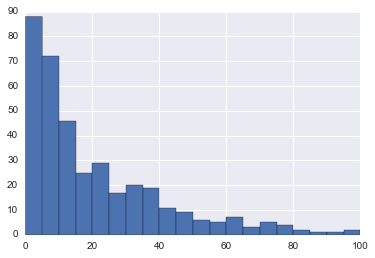

In [39]:
# Find the 95% threshold
n_bins = 20
n, bins, patches=plt.hist(rank_medians[:,1].astype('float64'), bins=n_bins, range=(0,100))
vals, _,_ = binned_statistic(list(rank_medians[:,1]), list(rank_medians[:,2]), bins=bins, statistic='median')

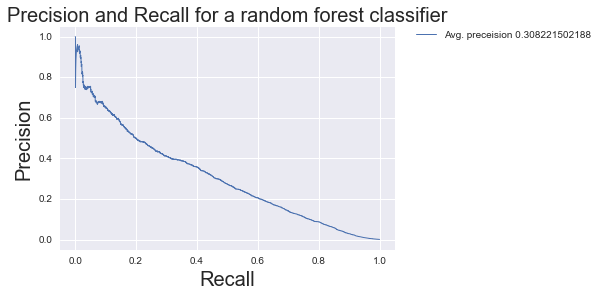

In [40]:
mean_avg_precision = average_precision_score(y_test, preds[:,1])
precision, recall, thresholds = precision_recall_curve(y_test, preds[:,1])
plt.plot(recall, precision, lw=1, label='Avg. preceision {}'.format(mean_avg_precision))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.title('Precision and Recall for a random forest classifier', fontsize=20)
plt.legend(fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
%%time
gb = GradientBoostingClassifier(n_estimators=20, max_features='sqrt', loss='exponential', subsample=0.85, max_leaf_nodes=20)
gb.fit(X_train, y_train)

In [ ]:
preds = gb.predict_proba(X_test)
rank_medians = sorted_scores(zip(X_test.index, preds), GCC)

In [ ]:
mean_avg_precision = average_precision_score(y_test, preds[:,1])
precision, recall, thresholds = precision_recall_curve(y_test, preds[:,1])
plt.plot(recall, precision, lw=1, label='Avg. preceision {}'.format(mean_avg_precision))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.title('Precision and Recall for a random forest classifier', fontsize=20)
plt.legend(fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier()
rn = RadiusNeighborsClassifier()

In [ ]:
%%time
knn.fit(X_train,y_train)

In [ ]:
preds = knn.predict_proba(X_test)
rank_medians = sorted_scores(zip(X_test.index, preds), GCC)

In [ ]:
mean_avg_precision = average_precision_score(y_test, preds[:,1])
precision, recall, thresholds = precision_recall_curve(y_test, preds[:,1])
plt.plot(recall, precision, lw=1, label='Avg. preceision {}'.format(mean_avg_precision))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.title('Precision and Recall for a random forest classifier', fontsize=20)
plt.legend(fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
n, bins, patches = ax1.hist(rank_medians[:,1].astype('float64'), bins=n_bins, range=(0,100))
vals, _,_ = binned_statistic(list(rank_medians[:,1]), list(rank_medians[:,2]), bins=bins, statistic='median')
ax2 = ax1.twinx()
ax2.plot(bins[:-1], vals, 'r', label='Median outdegree')
ax1.set_xlabel('Median probability rank of true links',fontsize=20)
ax1.set_ylabel('Count', fontsize=20)
for tick in ax1.get_yticklabels():
    tick.set_fontsize(15)
ax2.set_ylabel('Degree',fontsize=20)
for tick in ax2.get_yticklabels():
    tick.set_fontsize(15)
ax2.grid(None)
fig.set_figheight(10)
fig.set_figwidth(20)
ax2.legend(fontsize=15)

In [ ]:
positions = []
edges = []
for predictions in srt_preds.itervalues():
    if predictions[:,2].any():
        curr_pos = np.nonzero(predictions[:,2])[0]
        positions += list(curr_pos)
        edges += list(predictions[curr_pos, 0])
epcn = np.array(zip(edges, positions, X_test.loc[edges, 'common_neighbors'], y_test.loc[edges]))

In [ ]:
fig, ax1 = plt.subplots()
n, bins, patches = ax1.hist(epcn[:,1].astype('float64'), bins=n_bins)
vals, _,_ = binned_statistic(list(epcn[:,1]), list(epcn[:,2]), bins=bins, statistic='mean')
ax2 = ax1.twinx()
ax2.plot(bins[:-1], vals, 'r', label='Mean nr. of common neighbors')
ax1.set_xlabel('Rank',fontsize=20)
ax1.set_ylabel('Count', fontsize=20)
for tick in ax1.get_yticklabels():
    tick.set_fontsize(15)
ax2.set_ylabel('Nr. of common neighbors',fontsize=20)
for tick in ax2.get_yticklabels():
    tick.set_fontsize(15)
ax2.grid(None)
fig.set_figheight(10)
fig.set_figwidth(20)
ax2.legend(fontsize=15)
ax1.set_title('Rank distribution of true edges for all nodes', fontsize=20)

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
prec_reca_rank = []
ranks = [1,2,5,10,20,50,100,1000, len(GCC.nodes())]
for rank in ranks:
    pred_at_rank = pos_and_y[:,0] <= rank - 1
    prec=precision_score(pos_and_y[:,1], pred_at_rank)
    reca=recall_score(pos_and_y[:,1], pred_at_rank)
    prec_reca_rank.append((prec,reca,rank))
plt.plot([reca for _,reca,_ in prec_reca_rank], [prec for prec,_,_ in prec_reca_rank])
plt.xlabel('Recall')
plt.ylabel('Precison')
plt.title('Precision/Recall for varying rank threshold')

In [ ]:


n = G_train.nodes()[0]
edg = G_train.in_edges(n, data=True)

In [ ]:
iat = []
for _, item, nxt in neighborhood(edg):
    if nxt:
        iat.append(nxt[2]['date'] - item[2]['date'])

In [ ]:
iat

The results for the validated model is shown below, both with the confusion matrix for a 50% threshold and the precision recall curve.

## Burstiness

In [ ]:
def iter_w_neighbors(iterable):
    """
    Easy access of previous and next item in a list
    """
    iterator = iter(iterable)
    prev = None
    item = iterator.next()  # throws StopIteration if empty.
    for next in iterator:
        yield (prev,item,next)
        prev = item
        item = next
    yield (prev,item,None)


iat = []
for node in G_train.nodes_iter():
    for _, cur_edge, next_edge in iter_w_neighbors(G_train.in_edges_iter(node, data=True)):
        if next_edge:
            iat.append(abs((next_edge[2]['date'] - cur_edge[2]['date']).days) + 1)
iat = np.array(iat)

In [ ]:
liat=math.log10(X_train)

In [ ]:
iat = np.array(iat)

In [ ]:
td = np.array(X_train.loc[:, 'time_difference'])

In [ ]:
(td+1.0).min()

In [ ]:
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax2.hist(np.log10(iat),bins=20)
ax1.hist(np.log10(X_train.loc[y_train == False, 'time_difference']+1.0), bins=20)

# Supervised Results

Finally a comparison between logistic regression, random forests and the best unsupervised classifier, Adamic/Adar. As can be seen random forests comes out the winner for now.

In [ ]:
fig=plt.figure(figsize=(22,10))
fig.suptitle('ROC and Precision / Recall for all classifiers', fontsize=20)
rf_preds = rfe_forest.predict_proba(X_test)
lr_preds = l1_log_model.predict_proba(X_test)
ax1 = plt.subplot(1,2,1)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
fpr, tpr, _ = roc_curve(y_test, rf_preds[:,1])
ax1.plot(fpr, tpr, lw=1, label='Random forest')
fpr, tpr, _ = roc_curve(y_test, lr_preds[:,1])
ax1.plot(fpr, tpr, lw=1, label='Logistic regression')
fpr, tpr, _ = roc_curve(y_test, X_test.loc[:, 'adamic_adar'])
ax1.plot(fpr, tpr, lw=1, label='Adamic/Adar')
ax1.set_xlabel('False positive rate', fontsize=20)
ax1.set_ylabel('True positive rate', fontsize=20)

ax2 = plt.subplot(1,2,2)
ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
mean_avg_precision = average_precision_score(y_test, rf_preds[:,1])
precision, recall, thresholds = precision_recall_curve(y_test, rf_preds[:,1])
ax2.plot(recall, precision, lw=1, label='Random forest, avg. precision {:.3f}'.format(mean_avg_precision))
mean_avg_precision = average_precision_score(y_test, lr_preds[:,1])
precision, recall, thresholds = precision_recall_curve(y_test, lr_preds[:,1])
ax2.plot(recall, precision, lw=1, label='Logistic regression, avg. precision {:.3f}'.format(mean_avg_precision))
mean_avg_precision = average_precision_score(y_test, X_test.loc[:, 'adamic_adar'])
precision, recall, thresholds = precision_recall_curve(y_test, X_test.loc[:, 'adamic_adar'])
ax2.plot(recall, precision, lw=1, label='Adamic/Adar, avg. precision {:.3f}'.format(mean_avg_precision))
ax2.set_xlabel('Recall', fontsize=20)
ax2.set_ylabel('Precision', fontsize=20)
ax2.legend(fontsize=15)
plt.show()

In [ ]:
best_params.update({'class_weight': None})
rf = RandomForestClassifier(**best_params)
log_model = LogisticRegression(C=1e4, penalty='l1')
rf.fit(X_train, y_train)
log_model.fit(X_train, y_train)

In [ ]:

fig=plt.figure(figsize=(22,10))
fig.suptitle('ROC and Precision / Recall for all classifiers', fontsize=20)
rf_preds = rf.predict_proba(X_test)
lr_preds = log_model.predict_proba(X_test)
ax1 = plt.subplot(1,2,1)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
fpr, tpr, _ = roc_curve(y_test, rf_preds[:,1])
ax1.plot(fpr, tpr, lw=1, label='Random forest')
fpr, tpr, _ = roc_curve(y_test, lr_preds[:,1])
ax1.plot(fpr, tpr, lw=1, label='Logistic regression')
fpr, tpr, _ = roc_curve(y_test, X_test.loc[:, 'adamic_adar'])
ax1.plot(fpr, tpr, lw=1, label='Adamic/Adar')
ax1.set_xlabel('False positive rate', fontsize=20)
ax1.set_ylabel('True positive rate', fontsize=20)

ax2 = plt.subplot(1,2,2)
ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
mean_avg_precision = average_precision_score(y_test, rf_preds[:,1])
precision, recall, thresholds = precision_recall_curve(y_test, rf_preds[:,1])
ax2.plot(recall, precision, lw=1, label='Random forest, avg. precision {:.3f}'.format(mean_avg_precision))
mean_avg_precision = average_precision_score(y_test, lr_preds[:,1])
precision, recall, thresholds = precision_recall_curve(y_test, lr_preds[:,1])
ax2.plot(recall, precision, lw=1, label='Logistic regression, avg. precision {:.3f}'.format(mean_avg_precision))
mean_avg_precision = average_precision_score(y_test, X_test.loc[:, 'adamic_adar'])
precision, recall, thresholds = precision_recall_curve(y_test, X_test.loc[:, 'adamic_adar'])
ax2.plot(recall, precision, lw=1, label='Adamic/Adar, avg. precision {:.3f}'.format(mean_avg_precision))
ax2.set_xlabel('Recall', fontsize=20)
ax2.set_ylabel('Precision', fontsize=20)
ax2.legend(fontsize=15)
plt.show()

## Results on decimated network

The evaluation methods used so far all assume that all the information regarding a link between two candidates is known, i.e. all older links in the network except the one being evaluated are intact. It is interesting to expose the classifier to the more adversarial task of finding links in a decimated network, since this corresponds to a network where only some of the links are observed, something which for instance is relevant for a recommender engine where the user is still in the process of adding references to the verdict.

Two different ways to evaluate the decimated network are relevant:

* Remove a percentage of links at random from the training network while keeping the test network intact.
* Remove a percentage of links from each node to ensure that they are uniformly spread.This corresponds to the recommender engine case.


In [ ]:
%%time
# Partition the edges
# Find the edges belonging to the test candidates that have a degree higher than 1
deg_over_two = [n for n,d in GCC.out_degree().iteritems() if d > 1]
removable_edges = GCC.edges(deg_over_two)
# Partition the edges
n_partitions = 3
edge_partitions = np.array_split(removable_edges, n_partitions)
G_dec = GCC.copy()
G_dec.remove_edges_from(edge_partitions[0])
# Prepare a single year test set
test_year = 2013
GRAPH = 'cjeu'
nodes_test = [n[0] for n in slice_graph_by_year(test_year, test_year, GCC)]
# Create a training set
G_train_dec = G_dec.copy()
G_train_dec.remove_nodes_from(nodes_test)
test_candidates = [(source, target, {}) for target in GCC.nodes() for source in nodes_test 
                   if source !=target]
test_data = get_features(GCC, test_candidates, str(test_year) + "_part_{}".format(n_partitions))
X_test_dec = test_data.ix[:, [col for col in test_data.columns if col not in ['edge', 'source', 'target']]]
y_test_dec = test_data['edge']
del test_data

In [ ]:
# Training set consisting of the nodes of the preceding year
train_year = 2012
nodes_train = [n[0] for n in slice_graph_by_year(train_year, train_year, G_train_dec)]
train_candidates = [(source, target,{}) for target in G_train_dec.nodes() for source in nodes_train if not source==target]
train_data = get_features(G_train_dec, train_candidates, str(train_year) + "_part_{}".format(n_partitions))
y_train_dec = train_data['edge']
X_train_dec = train_data.loc[:, [col for col in train_data.columns if col not in ['edge', 'source', 'target']]]

In [ ]:
best_params.update({'n_estimators': 30, 'warm_start': False, 'oob_score': False})
rf_dec = RandomForestClassifier(**best_params)
rf = RandomForestClassifier(**best_params)

In [ ]:
rf_dec.fit(X_train_dec, y_train_dec)
rf.fit(X_train, y_train)

In [ ]:
preds_dec = rf_dec.predict_proba(X_test_dec)
preds_dec_fm = rf.predict_proba(X_test_dec)
preds = rf.predict_proba(X_test)
mean_avg_precision = average_precision_score(y_test, preds[:,1])
mean_avg_precision_dec = average_precision_score(y_test, preds_dec[:,1])
mean_avg_precision_dec_fm = average_precision_score(y_test, preds_dec_fm[:,1])

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, preds[:,1])
plt.plot(recall, precision, lw=1, label='Avg. precision {:.3f}'.format(mean_avg_precision))
precision, recall, thresholds = precision_recall_curve(y_test_dec, preds_dec_fm[:,1])
plt.plot(recall, precision, lw=1, label='Avg. precision decimated, full model {:.3f}'.format(mean_avg_precision_dec_fm))
precision, recall, thresholds = precision_recall_curve(y_test_dec, preds_dec[:,1])
plt.plot(recall, precision, lw=1, label='Avg. precision decimated {:.3f}'.format(mean_avg_precision_dec))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.title('Comparison of 1/3 decimated and full network', fontsize=20)
plt.legend(fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
print classification_report(y_test_dec, pred_dec)

In [ ]:
print classification_report(y_test, pred)

In [ ]:
indexed_scores = zip(X_test_dec.index, preds_dec)
ranked_medians_dec = sorted_scores(indexed_scores, G_dec)

In [ ]:
from scipy.stats import binned_statistic
fig, ax1 = plt.subplots()
n, bins, patches = ax1.hist(ranked_medians_dec[:,1].astype('float64'))
vals, _,_ = binned_statistic(list(ranked_medians_dec[:,1]), list(ranked_medians_dec[:,2]), bins=bins, statistic='median')
ax2 = ax1.twinx()
ax2.plot(bins[:-1], vals, 'r', label='Median outdegree')
ax1.set_xlabel('Median probability rank of true links',fontsize=20)
ax1.set_ylabel('Count', fontsize=20)
for tick in ax1.get_yticklabels():
    tick.set_fontsize(15)
ax2.set_ylabel('Degree',fontsize=20)
for tick in ax2.get_yticklabels():
    tick.set_fontsize(15)
ax2.grid(None)
fig.set_figheight(10)
fig.set_figwidth(20)
ax2.legend(fontsize=15)

In [ ]:
### COMPUTE FEATURES FOR ALL YEARS ###
#years = range(1970, 1995)
#years.reverse()
#nodes_done = [n[0] for n in slice_graph_by_year(2013, 1995, GCC)]
#G_cur = GCC.copy()
#G_cur.remove_nodes_from(nodes_done)
#for year in years:
#    nodes_cur = [n[0] for n in slice_graph_by_year(year, year, G_cur)]
#    G_next = G_cur.copy()
#    G_next.remove_nodes_from(nodes_cur)
#    cur_candidates = [(source, target, {}) for target in G_cur.nodes() for source in nodes_cur if not source==target]
#    get_features(G_cur, cur_candidates, year)
#    G_cur = G_next

# References

<a name="cite-Lu20111150"/><sup>[^](#ref-1) [^](#ref-4) </sup>Lü, Linyuan and Zhou, Tao. 2011. _Link prediction in complex networks: A survey _. [URL](http://www.sciencedirect.com/science/article/pii/S037843711000991X)

<a name="cite-Wang2014"/><sup>[^](#ref-2) [^](#ref-3) </sup>Wang, Peng
and Xu, BaoWen
and Wu, YuRong
and Zhou, XiaoYu. 2014. _Link prediction in social networks: the state-of-the-art_. [URL](http://dx.doi.org/10.1007/s11432-014-5237-y)

<a name="cite-LibenNowell2004"/><sup>[^](#ref-5) [^](#ref-8) </sup>Liben-Nowell, David and Kleinberg, Jon. 2003. _The Link Prediction Problem for Social Networks_. [URL](http://doi.acm.org/10.1145/956863.956972)

<a name="cite-directedSchall"/><sup>[^](#ref-6) [^](#ref-7) </sup>Schall, Daniel. 2014. _Link prediction in directed social networks_. [URL](http://dx.doi.org/10.1007/s13278-014-0157-9)

<a name="cite-Derlen2013coo"/><sup>[^](#ref-9) </sup>Derl&eacute;n, Mattias and Lindholm, Johan and Rosvall, Martin and Mirshahvalad, Atieh. 2013. _Coherence out of chaos : mapping European union law by running randomly through the maze of CJEU case law_.

<a name="cite-Rosvall2010"/><sup>[^](#ref-10) </sup>Rosvall, M.
and Axelsson, D.
and Bergstrom, T. C.. 2010. _The map equation_. [URL](http://dx.doi.org/10.1140/epjst/e2010-01179-1)

<a name="cite-KatzIndex"/><sup>[^](#ref-11) </sup>Katz, Leo. 1953. _A new status index derived from sociometric analysis_. [URL](http://dx.doi.org/10.1007/BF02289026)

<a name="cite-LHN2"/><sup>[^](#ref-12) </sup>Leicht, E. A. and Holme, Petter and Newman, M. E. J.. 2006. _Vertex similarity in networks_. [URL](http://link.aps.org/doi/10.1103/PhysRevE.73.026120)

<a name="cite-Fouss06random-walkcomputation"/><sup>[^](#ref-13) </sup>Fouss, François and Pirotte, Alain and Renders, Jean-michel and Saerens, Marco. 2006. _Random-walk computation of similarities between nodes of a graph, with application to collaborative recommendation_.

